In [1]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_percentage_error

# Library data visualization
import plotly
import matplotlib.pylab as pl
import matplotlib as m
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
from matplotlib import pyplot as plt
from IPython.display import SVG

from scipy import stats
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
warnings.simplefilter(action='ignore', category=Warning)

import math
import optuna
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from prettytable import PrettyTable
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from typing import Union
from itertools import product
from tqdm.notebook import tqdm
from scipy.ndimage import gaussian_filter1d
import gc
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, f1_score, precision_score
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
file_path = "/kaggle/input/q-1-weather-forecasting-data/weather_data.csv" 
weather = pd.read_csv(file_path)
weather

date  avg_temperature   humidity  avg_wind_speed rain_or_not  \
0    2023-01-01        23.745401  46.140905        7.845981        Rain   
1    2023-01-02        30.030503  59.876587        5.382457        Rain   
2    2023-01-03        28.365224  51.464618       13.158008        Rain   
3    2023-01-04        27.550929  53.103799        5.886677        Rain   
4    2023-01-05        23.639303  57.826186       12.248992        Rain   
..          ...              ...        ...             ...         ...   
306  2023-11-03        22.072834  37.756910        4.729355     No Rain   
307  2023-11-04        19.645885  42.190604        8.092369     No Rain   
308  2023-11-05        23.884496  36.205508       11.860847        Rain   
309  2023-11-06        18.168418  34.785000        4.781288     No Rain   
310  2023-11-07        19.389714  37.717416        9.388371     No Rain   

     cloud_cover     pressure  
0      20.851051   992.965681  
1      93.059521  1037.273025  
2      11.636640  1034.193357  
3      81.744971   968.610142  
4      38.062329  1030.264331  
..           ...          ...  
306    27.307081   954.564875  
307    51.807877   964.002410  
308    29.872557   977.681431  
309    94.067925  1047.153269  
310    25.929676   983.134701  

[311 rows x 7 columns]

In [3]:
weather = weather.drop_duplicates()

In [4]:
def customDescription(df: pd.DataFrame, numeric_only: bool = False):
    if numeric_only:
        df = df.select_dtypes(include=np.number)
    
    desc = pd.DataFrame(index=df.columns.to_list())
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['null'] = df.isnull().sum()
    
    # Calculate mode and handle multiple modes
    modes = df.mode()
    desc['mode'] = np.nan  # Default to NaN
    for col in df.columns:
        if len(modes[col].dropna()) == 1:  # Single mode exists
            desc.loc[col, 'mode'] = modes[col].iloc[0]
        else:  # Multiple modes
            desc.loc[col, 'mode'] = np.nan

    # Calculate least frequent value
    desc['least_frequent'] = np.nan  # Default to NaN
    for col in df.columns:
        value_counts = df[col].value_counts(dropna=False)
        if not value_counts.empty:
            least_freq_count = value_counts.min()  # Find the minimum frequency
            least_freq_values = value_counts[value_counts == least_freq_count].index
            
            if len(least_freq_values) == 1:  # If exactly one least frequent value exists
                desc.loc[col, 'least_frequent'] = least_freq_values[0]
            else:  # Multiple least frequent values
                desc.loc[col, 'least_frequent'] = np.nan
    
    # Handle numeric columns
    numeric_cols = df.select_dtypes(include=np.number)
    if not numeric_cols.empty:
        numeric_desc = numeric_cols.describe().T.drop(columns=['count', 'std', '25%', '50%', '75%'], axis=1)
        for col in numeric_cols.columns:
            desc.loc[col, 'mean'] = numeric_desc.loc[col, 'mean']
            desc.loc[col, 'min'] = numeric_desc.loc[col, 'min']
            desc.loc[col, 'max'] = numeric_desc.loc[col, 'max']
    
    # Handle datetime columns
    datetime_cols = df.select_dtypes(include=['datetime64[ns]', 'datetime64[ns, UTC]'])
    for col in datetime_cols.columns:
        desc.loc[col, 'min'] = df[col].min()
        desc.loc[col, 'max'] = df[col].max()
    
    return desc

In [5]:
customDescription(weather)

type  count  nunique  null  mode least_frequent  \
date              object    311      311     0   NaN            NaN   
avg_temperature  float64    296      243    15  35.0            NaN   
humidity         float64    296      239    15  30.0            NaN   
avg_wind_speed   float64    296      296    15   NaN            NaN   
rain_or_not       object    311        2     0  Rain        No Rain   
cloud_cover      float64    296      296    15   NaN            NaN   
pressure         float64    311      311     0   NaN            NaN   

                        mean         min          max  
date                     NaN         NaN          NaN  
avg_temperature    25.983840   15.000000    35.000000  
humidity           55.041385   30.000000    90.000000  
avg_wind_speed      7.556636    0.069480    56.636041  
rain_or_not              NaN         NaN          NaN  
cloud_cover        49.834827    0.321826    99.834751  
pressure         1001.059119  951.240404  1049.543752

In [6]:
weather['date'] = pd.to_datetime(weather['date'])
weather['rain_or_not'] = weather['rain_or_not'].map({'Rain': 1, 'No Rain': 0})
weather['rain_or_not'] = weather['rain_or_not'].astype('int')
weather = weather.sort_values(by='date')

In [7]:
customDescription(weather)

type  count  nunique  null  mode  least_frequent  \
date             datetime64[ns]    311      311     0   NaN             NaN   
avg_temperature         float64    296      243    15  35.0             NaN   
humidity                float64    296      239    15  30.0             NaN   
avg_wind_speed          float64    296      296    15   NaN             NaN   
rain_or_not               int64    311        2     0   1.0             0.0   
cloud_cover             float64    296      296    15   NaN             NaN   
pressure                float64    311      311     0   NaN             NaN   

                        mean                  min                  max  
date                     NaN  2023-01-01 00:00:00  2023-11-07 00:00:00  
avg_temperature    25.983840                 15.0                 35.0  
humidity           55.041385                 30.0                 90.0  
avg_wind_speed      7.556636              0.06948            56.636041  
rain_or_not         0.636656                  0.0                  1.0  
cloud_cover        49.834827             0.321826            99.834751  
pressure         1001.059119           951.240404          1049.543752

In [8]:
missing_dates = pd.date_range(weather['date'].min(), weather['date'].max()).difference(weather['date'])  
missing_dates

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

In [9]:
weather[weather.isnull().any(axis=1)]

date  avg_temperature  humidity  avg_wind_speed  rain_or_not  \
12  2023-01-13              NaN       NaN             NaN            0   
15  2023-01-16              NaN       NaN             NaN            1   
16  2023-01-17              NaN       NaN             NaN            0   
44  2023-02-14              NaN       NaN             NaN            1   
47  2023-02-17              NaN       NaN             NaN            1   
52  2023-02-22              NaN       NaN             NaN            0   
57  2023-02-27              NaN       NaN             NaN            1   
71  2023-03-13              NaN       NaN             NaN            0   
111 2023-04-22              NaN       NaN             NaN            1   
114 2023-04-25              NaN       NaN             NaN            1   
125 2023-05-06              NaN       NaN             NaN            1   
140 2023-05-21              NaN       NaN             NaN            1   
216 2023-08-05              NaN       NaN             NaN            0   
279 2023-10-07              NaN       NaN             NaN            1   
302 2023-10-30              NaN       NaN             NaN            0   

     cloud_cover     pressure  
12           NaN  1022.950823  
15           NaN  1011.022515  
16           NaN   963.535408  
44           NaN  1006.016818  
47           NaN   991.879332  
52           NaN  1015.417460  
57           NaN  1010.852727  
71           NaN  1004.353822  
111          NaN  1032.210316  
114          NaN  1046.447665  
125          NaN   965.795482  
140          NaN  1011.529803  
216          NaN  1006.044063  
279          NaN  1001.744635  
302          NaN   957.093222

In [10]:
weather.ffill(inplace=True)

In [11]:
weather

date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
0   2023-01-01        23.745401  46.140905        7.845981            1   
1   2023-01-02        30.030503  59.876587        5.382457            1   
2   2023-01-03        28.365224  51.464618       13.158008            1   
3   2023-01-04        27.550929  53.103799        5.886677            1   
4   2023-01-05        23.639303  57.826186       12.248992            1   
..         ...              ...        ...             ...          ...   
306 2023-11-03        22.072834  37.756910        4.729355            0   
307 2023-11-04        19.645885  42.190604        8.092369            0   
308 2023-11-05        23.884496  36.205508       11.860847            1   
309 2023-11-06        18.168418  34.785000        4.781288            0   
310 2023-11-07        19.389714  37.717416        9.388371            0   

     cloud_cover     pressure  
0      20.851051   992.965681  
1      93.059521  1037.273025  
2      11.636640  1034.193357  
3      81.744971   968.610142  
4      38.062329  1030.264331  
..           ...          ...  
306    27.307081   954.564875  
307    51.807877   964.002410  
308    29.872557   977.681431  
309    94.067925  1047.153269  
310    25.929676   983.134701  

[311 rows x 7 columns]

In [12]:
numerical_variables = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']
target_variable = 'rain_or_not'

# EDA

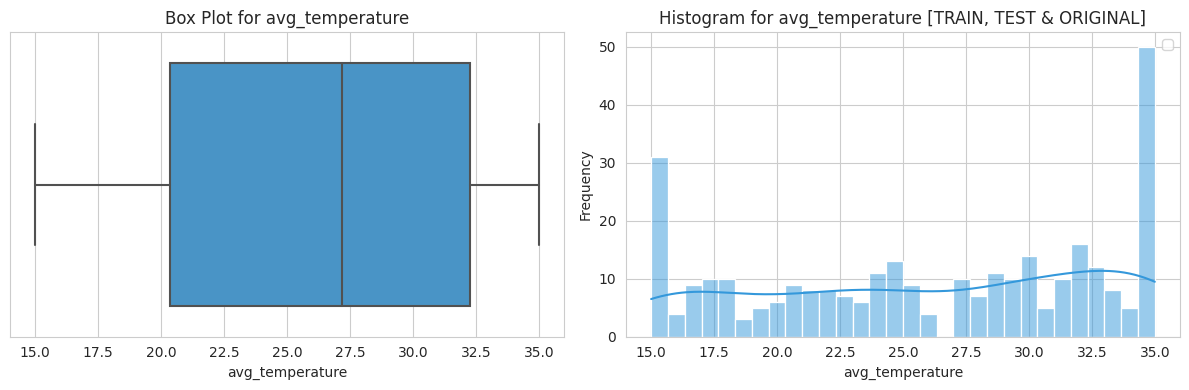

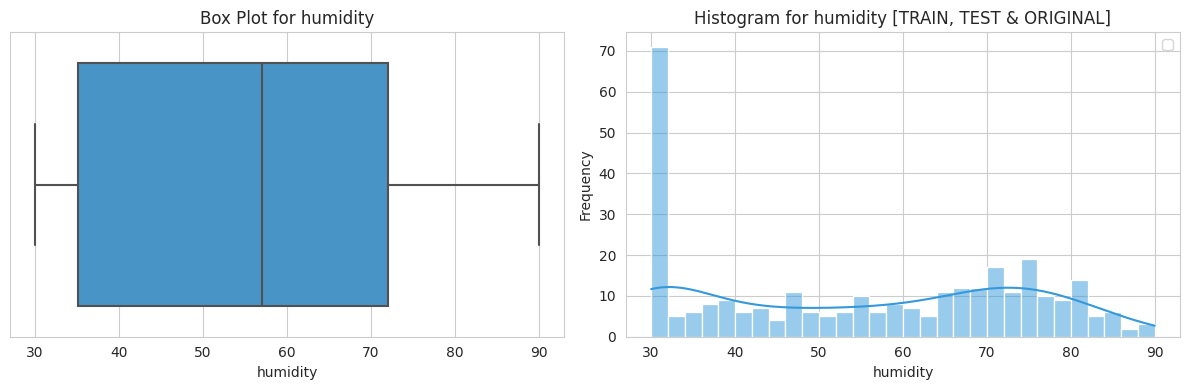

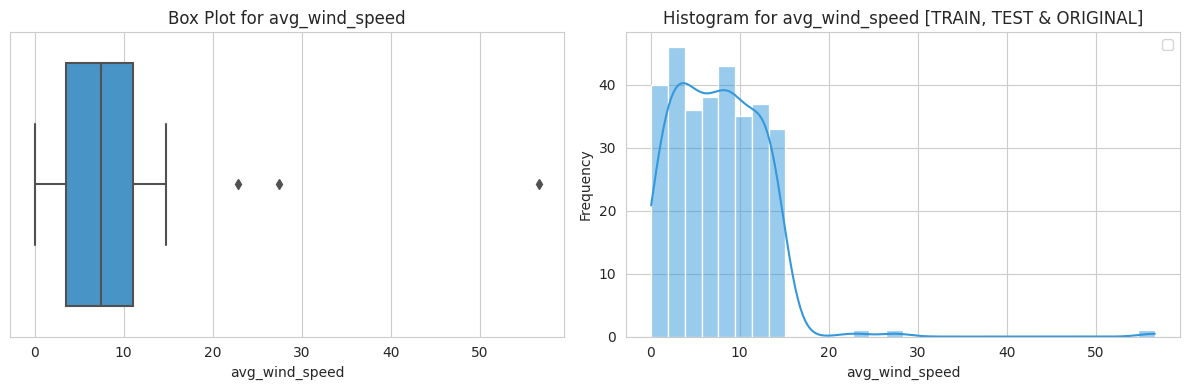

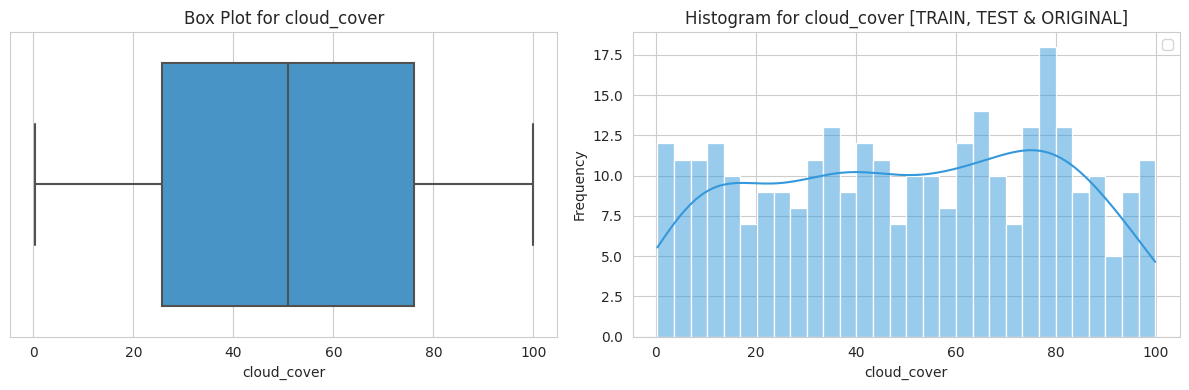

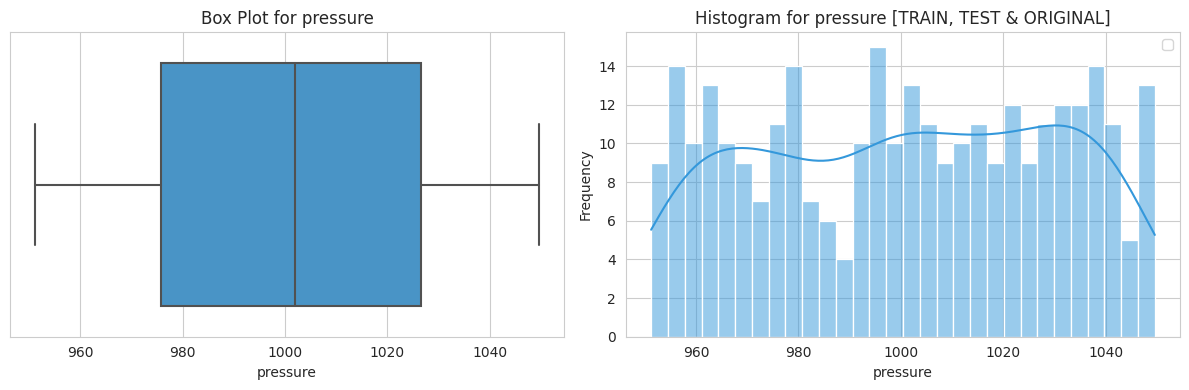

In [13]:
custom_palette = ['#3498db', '#e74c3c','#2ecc71']

variables = [col for col in weather.columns if col in numerical_variables]

def create_variable_plots(variable):
    sns.set_style('whitegrid')
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.boxplot(data=weather, x=variable, palette=custom_palette)
    plt.xlabel(variable)
    plt.title(f"Box Plot for {variable}")

    plt.subplot(1, 2, 2)
    sns.histplot(data=weather, x=variable, color=custom_palette[0], kde=True, bins=30)
    plt.xlabel(variable)
    plt.ylabel("Frequency")
    plt.title(f"Histogram for {variable}")
    plt.legend()

    plt.tight_layout()

    plt.show()

for variable in variables:
    create_variable_plots(variable)

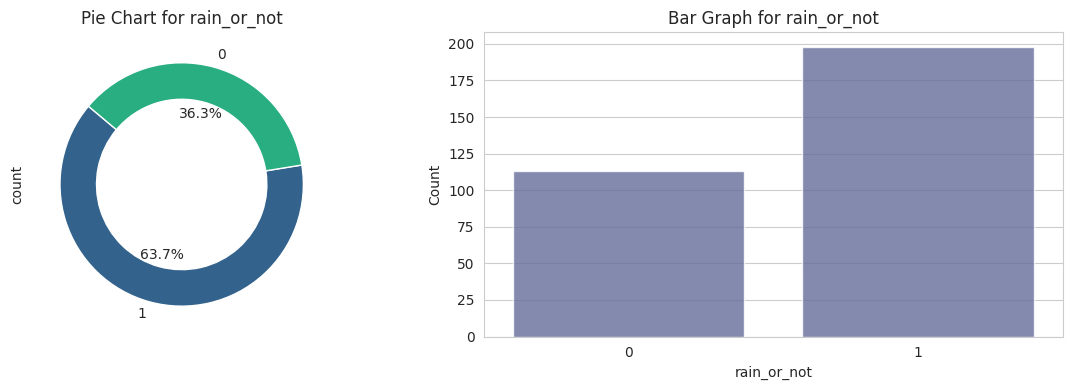

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pie_chart_palette = ['#33638d', '#28ae80', '#d3eb0c', '#ff9a0b', '#7e03a8', '#35b779', '#fde725', '#440154', '#90d743', '#482173', '#22a884', '#f8961e']

countplot_color = '#5C67A3'

# Function to create and display a row of plots for a single target variable
def create_target_plots(variable):
    sns.set_style('whitegrid')
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Pie Chart
    plt.subplot(1, 2, 1)
    weather[variable].value_counts().plot.pie(
        autopct='%1.1f%%', colors=pie_chart_palette, wedgeprops=dict(width=0.3), startangle=140
    )
    plt.title(f"Pie Chart for {variable}")

    # Bar Graph
    plt.subplot(1, 2, 2)
    sns.countplot(
        data=weather, 
        x=variable, 
        color=countplot_color,  # Using a single color for the countplot
        alpha=0.8  # Setting 80% opacity
    )
    plt.xlabel(variable)
    plt.ylabel("Count")
    plt.title(f"Bar Graph for {variable}")

    # Adjust spacing between subplots
    plt.tight_layout()
    
    # Show the plots
    plt.show()

# Perform univariate analysis for target variable
create_target_plots(target_variable)

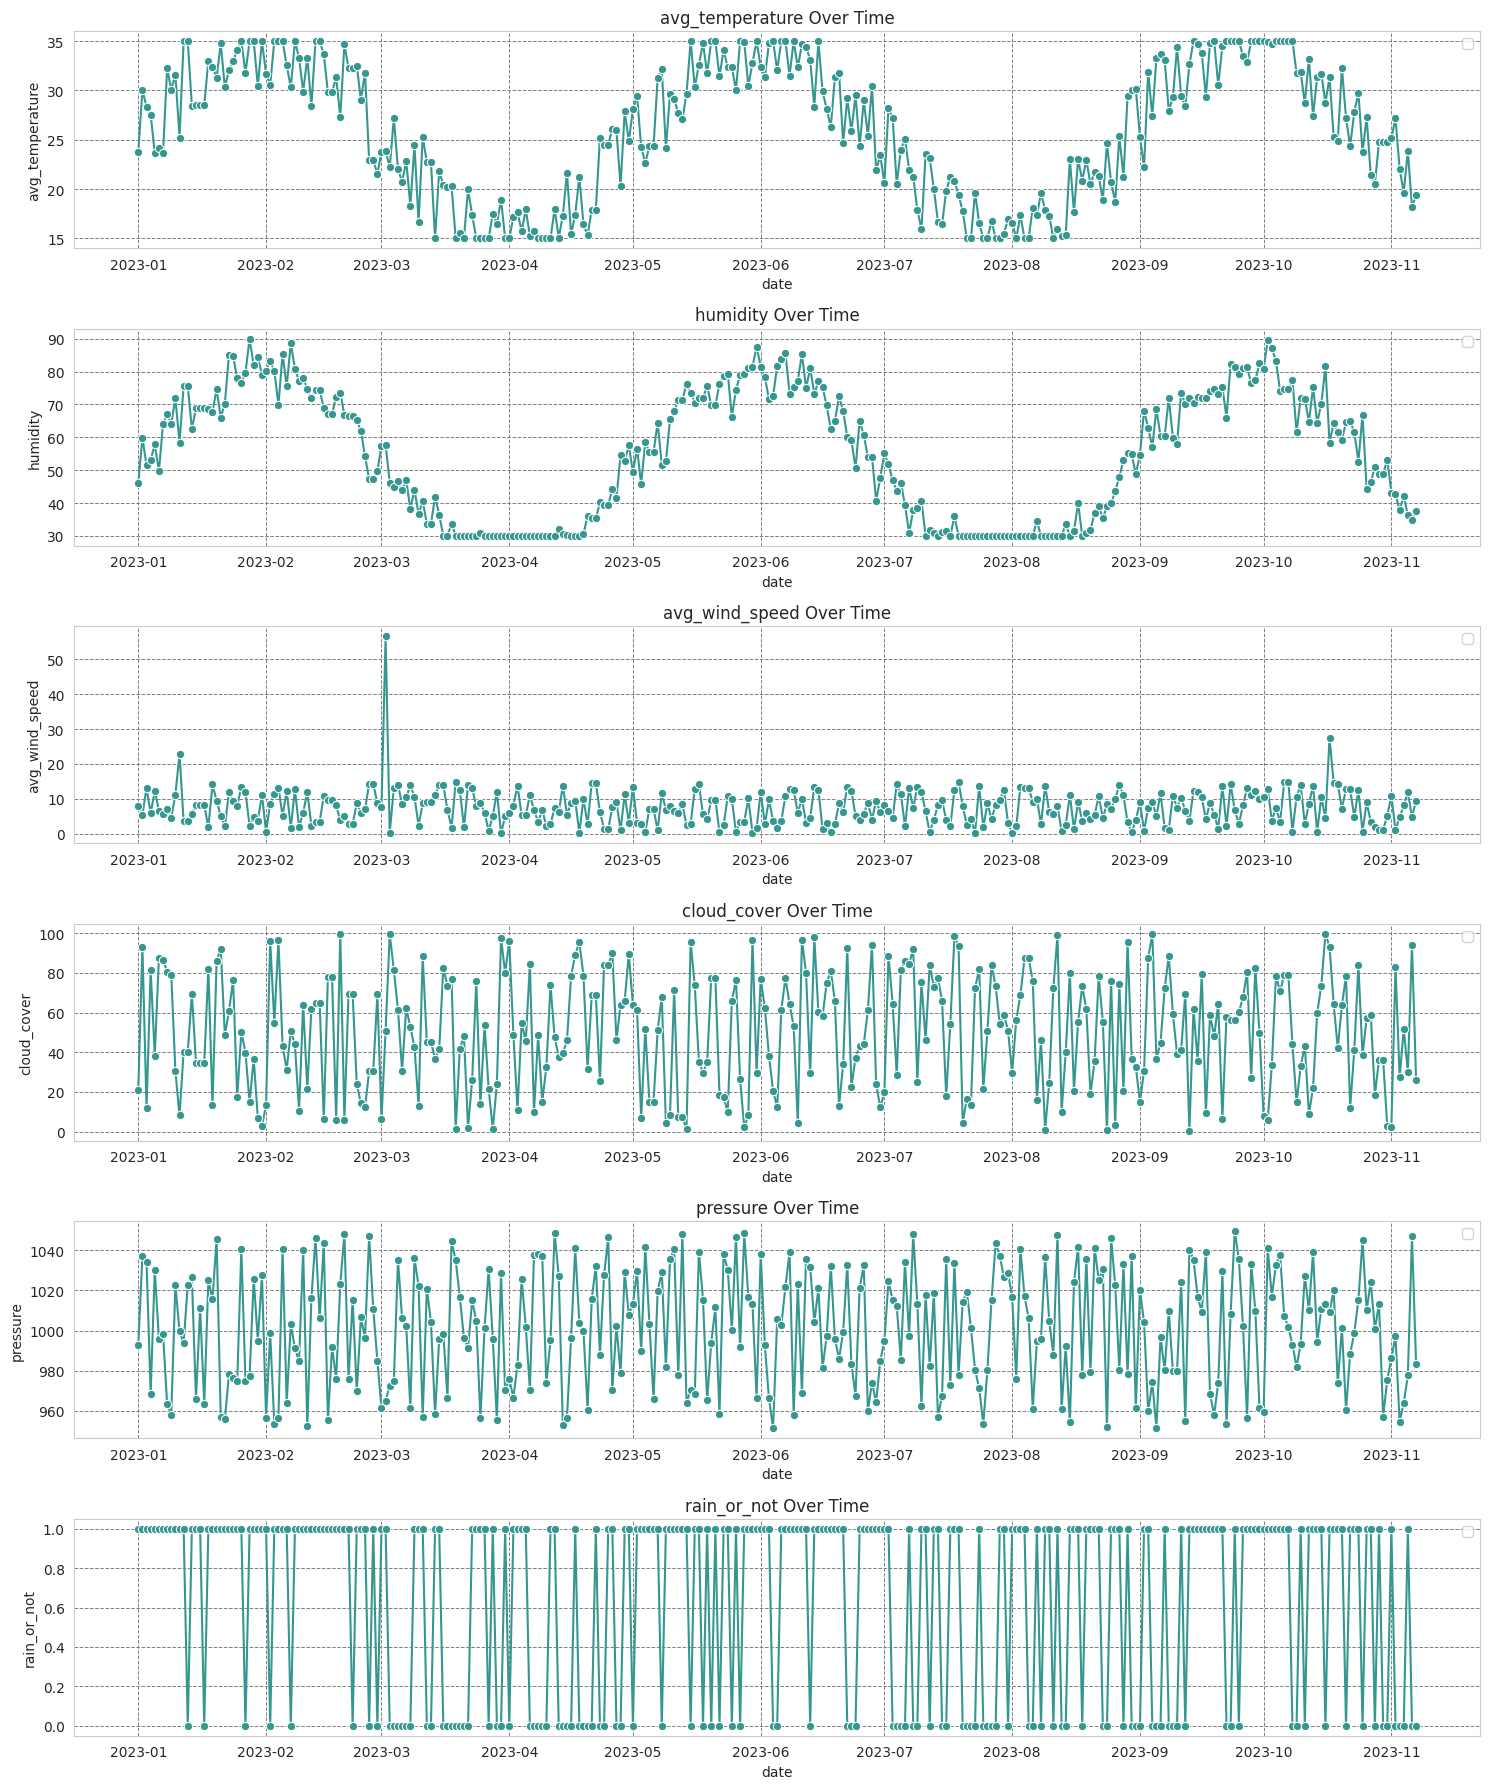

In [15]:
cmap = plt.get_cmap('BrBG')
colors = [cmap(0.8)]

numerical_features = numerical_variables + ['rain_or_not']

fig, axes = plt.subplots(len(numerical_features), 1, figsize=(15, len(numerical_features) * 3))

for i, feature in enumerate(numerical_features):
    sns.lineplot(data=weather, 
                 x=weather.date, 
                 y=feature, color=colors[0], marker='o', ax=axes[i])

    axes[i].set_title(f'{feature} Over Time')
    axes[i].set_xlabel('date')
    axes[i].set_ylabel(feature)
    axes[i].grid(color='gray', linestyle='--', linewidth=0.7)
    axes[i].legend()

plt.tight_layout()
plt.show()

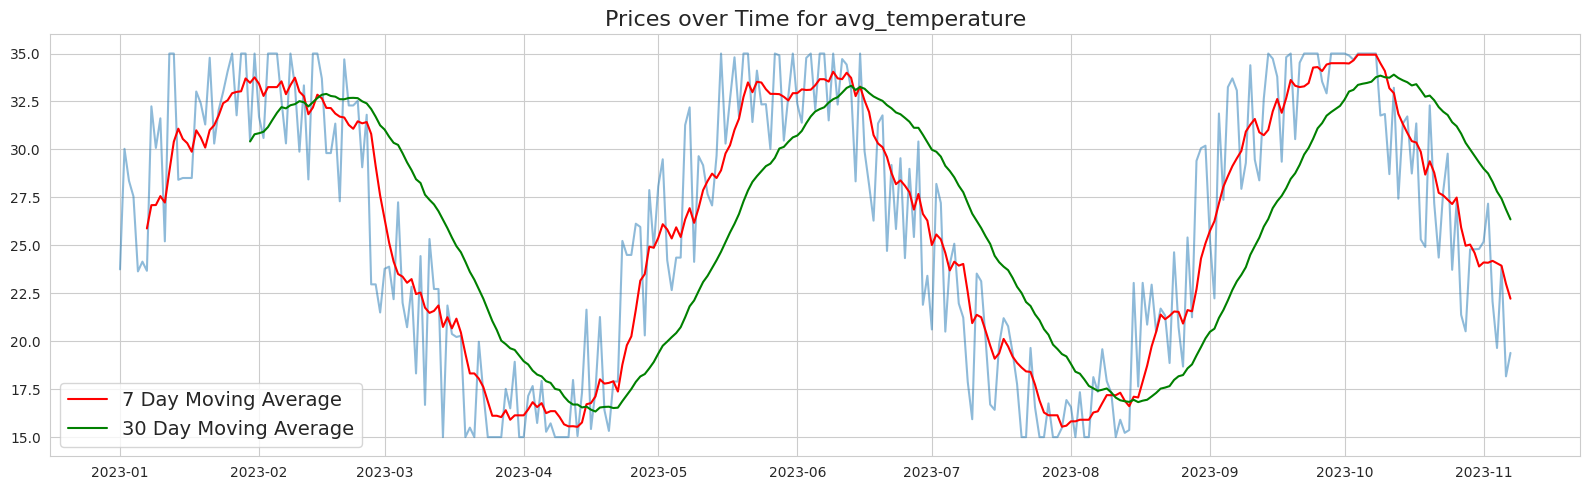

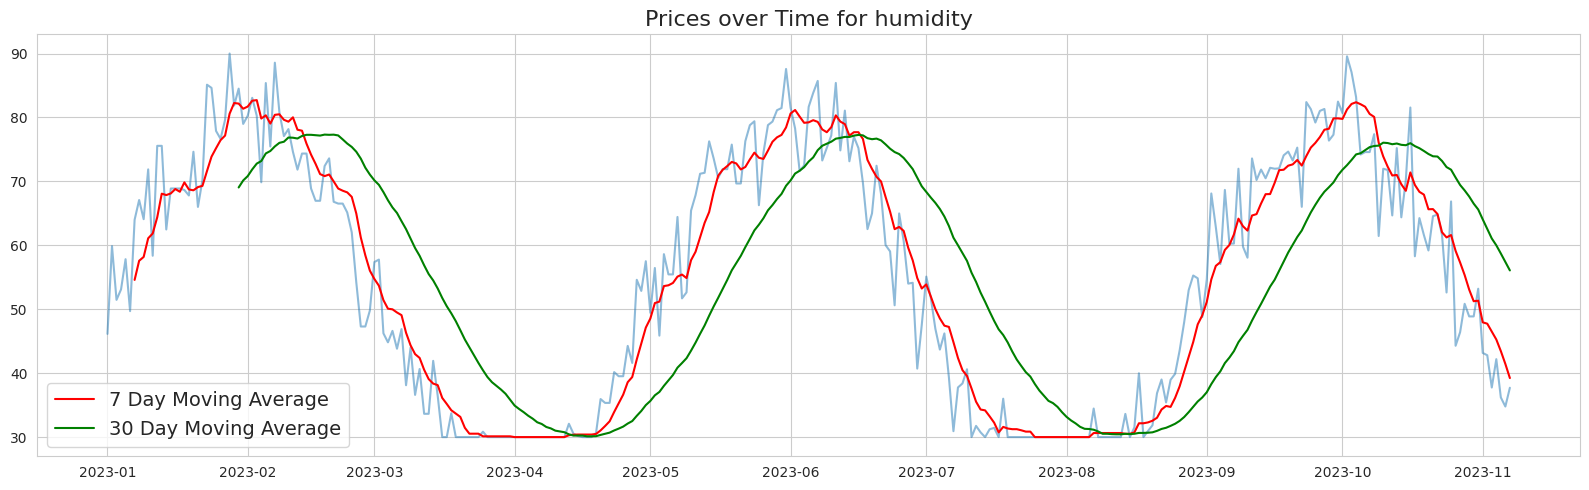

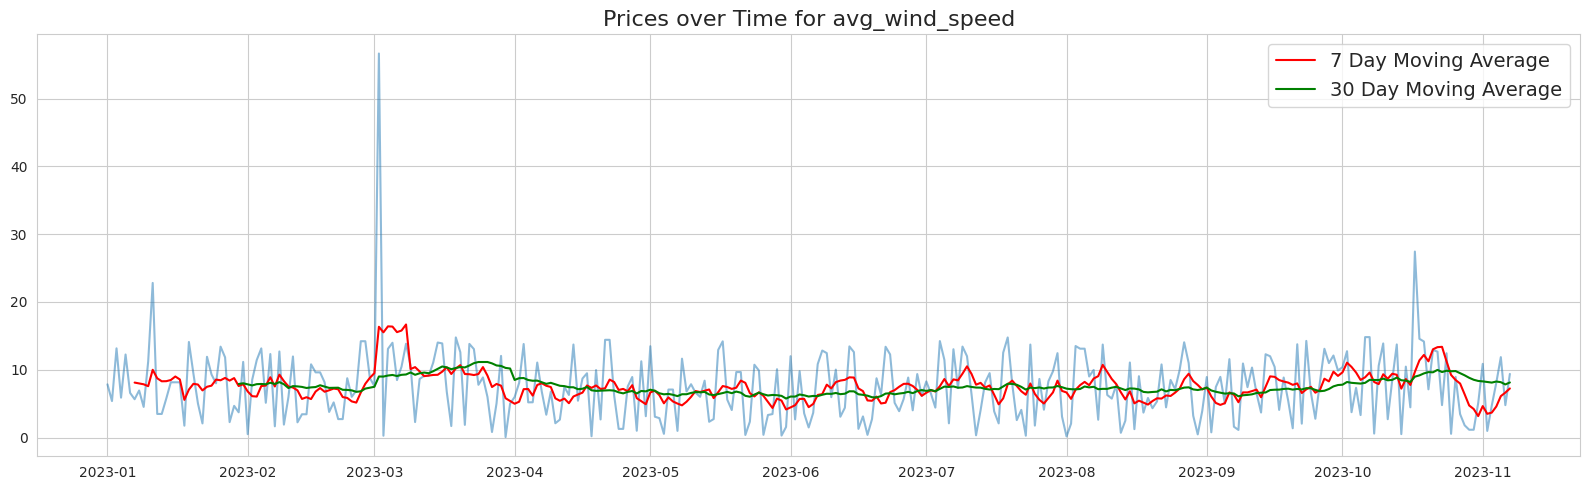

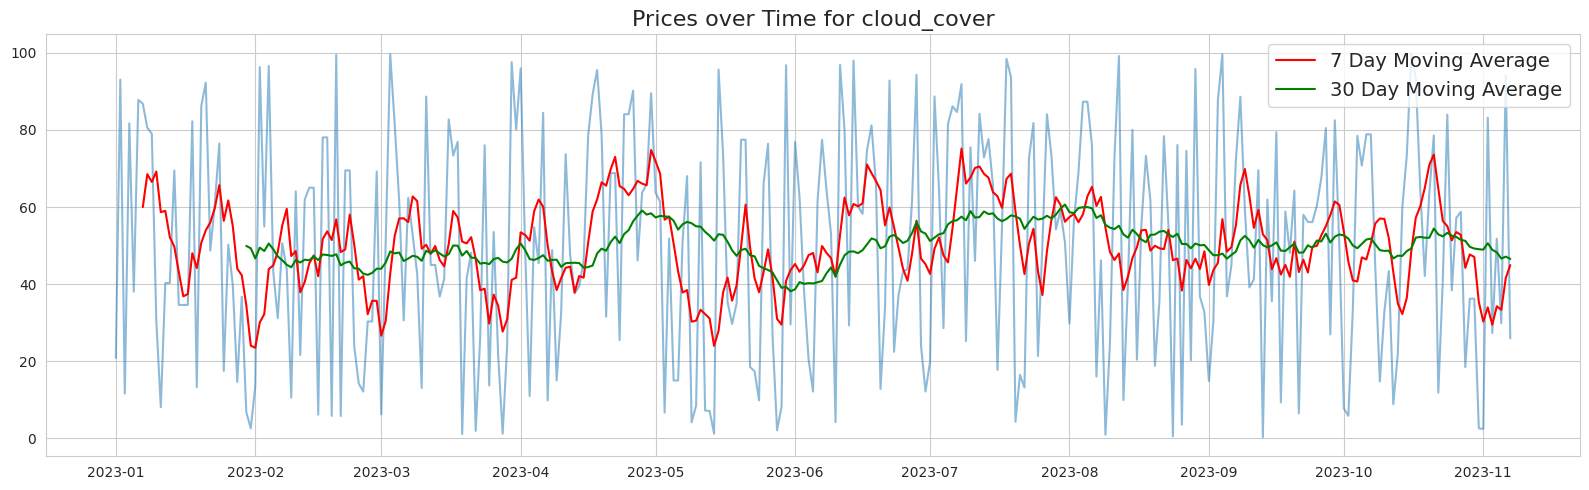

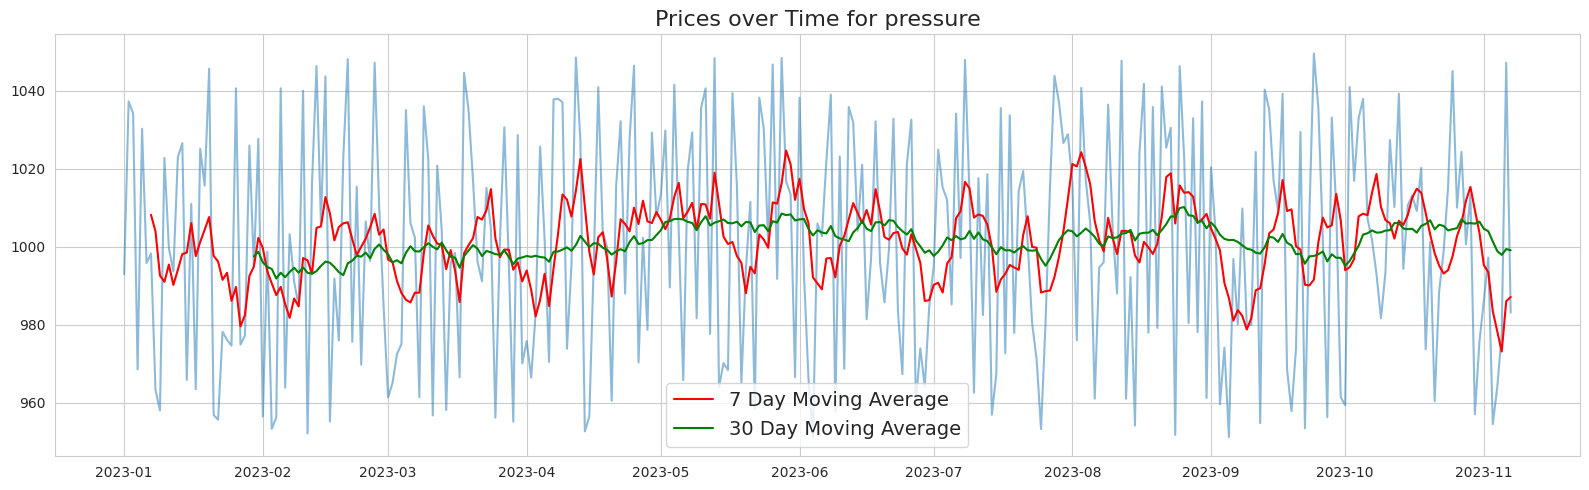

In [16]:
numerical_features = numerical_variables

for feature in numerical_features:
    plt.figure(figsize=(16, 5))
    
    # original time series
    plt.plot(weather['date'], weather[feature], marker='', linestyle='-', alpha=0.5)
    
    # 7-day moving average
    weather['7_day_ma'] = weather[feature].rolling(window=7).mean()
    plt.plot(weather['date'], weather['7_day_ma'], marker='', linestyle='-', color='red', label='7 Day Moving Average')
    
    # 30-day moving average
    weather['30_day_ma'] = weather[feature].rolling(window=30).mean()
    plt.plot(weather['date'], weather['30_day_ma'], marker='', linestyle='-', color='green', label='30 Day Moving Average')
        
    plt.title(f'Prices over Time for {feature}', fontsize=16)
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(rotation=0)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()
    weather = weather.drop(columns=['7_day_ma','30_day_ma'])

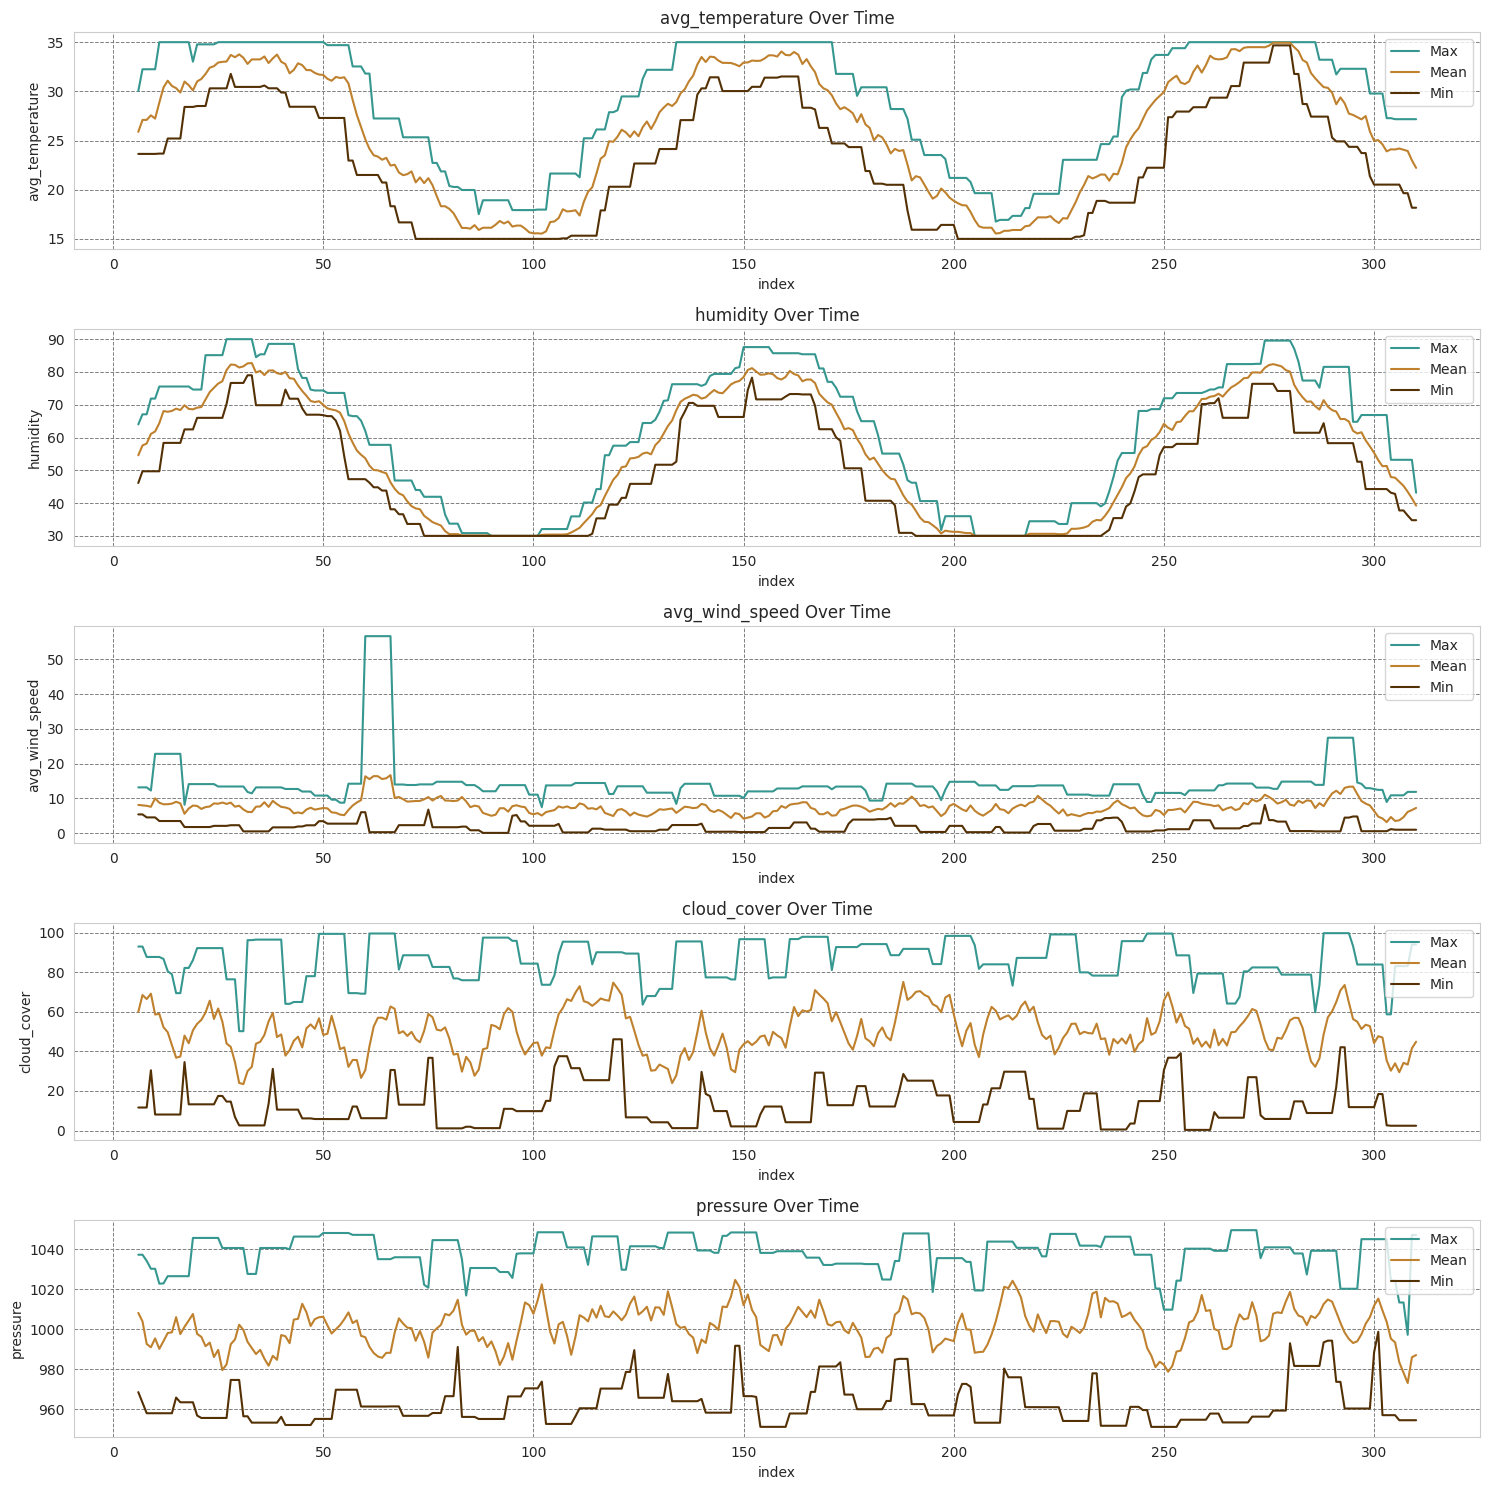

In [17]:
cmap = plt.get_cmap('BrBG')
colors = [cmap(0.8), cmap(0.2), cmap(0)]

numerical_features = numerical_variables

fig, axes = plt.subplots(len(numerical_features), 1, figsize=(15, len(numerical_features) * 3))

for i, feature in enumerate(numerical_features):
    rolling_max = weather[feature].rolling(window=7).max()
    rolling_mean = weather[feature].rolling(window=7).mean()
    rolling_min = weather[feature].rolling(window=7).min()
    
    axes[i].plot(rolling_max, label='Max', color=colors[0])
    axes[i].plot(rolling_mean, label='Mean', color=colors[1])
    axes[i].plot(rolling_min, label='Min', color=colors[2])

    axes[i].set_title(f'{feature} Over Time')
    axes[i].set_xlabel('index')
    axes[i].set_ylabel(feature)
    axes[i].grid(color='gray', linestyle='--', linewidth=0.7)
    axes[i].legend()

plt.tight_layout()
plt.show()

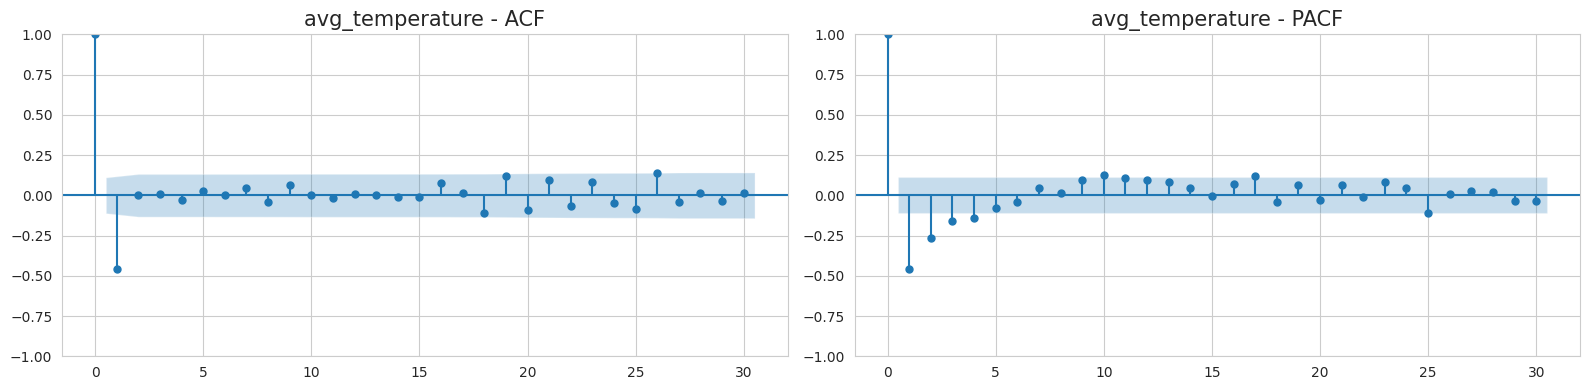

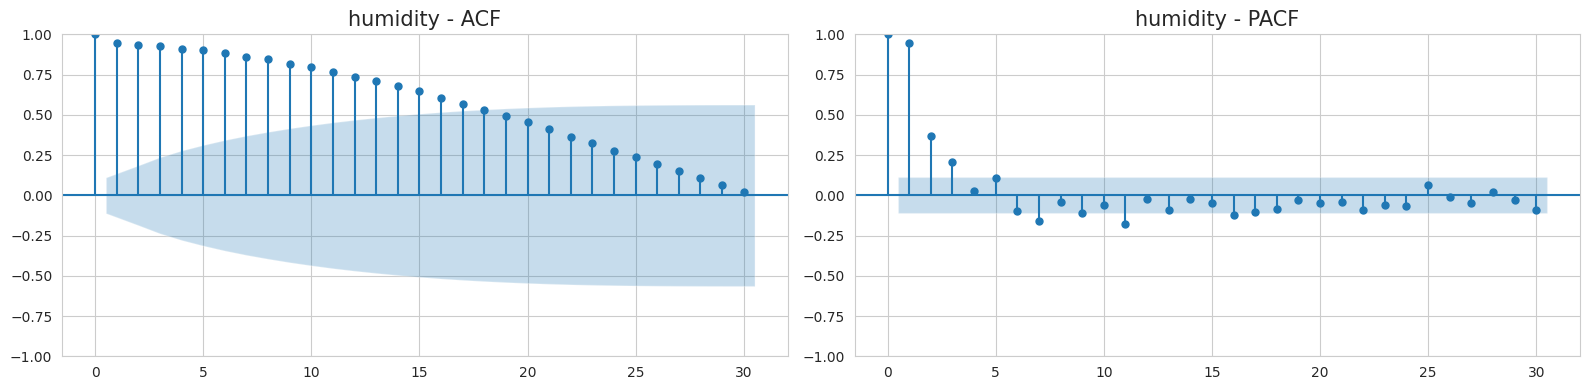

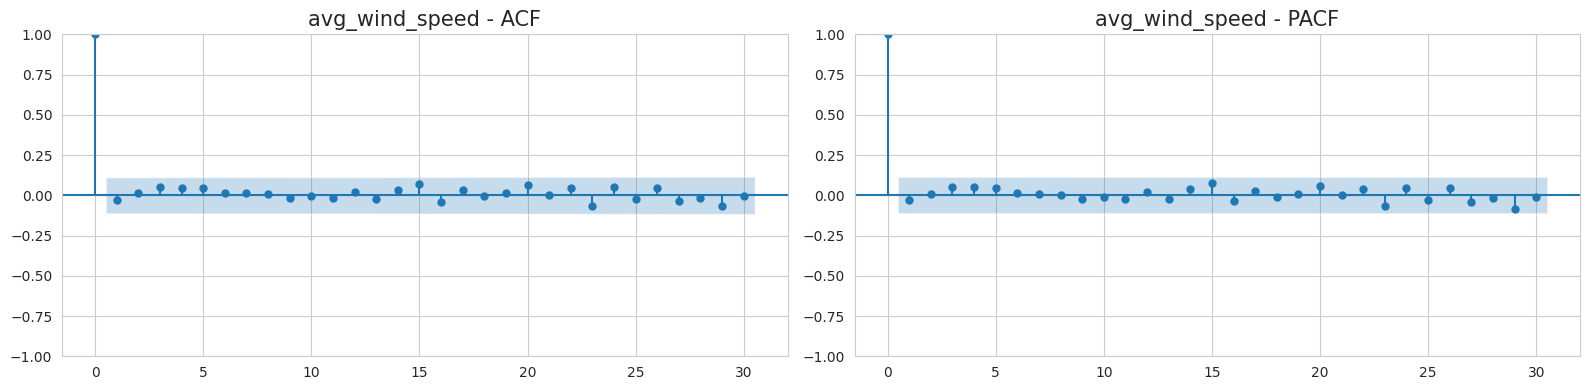

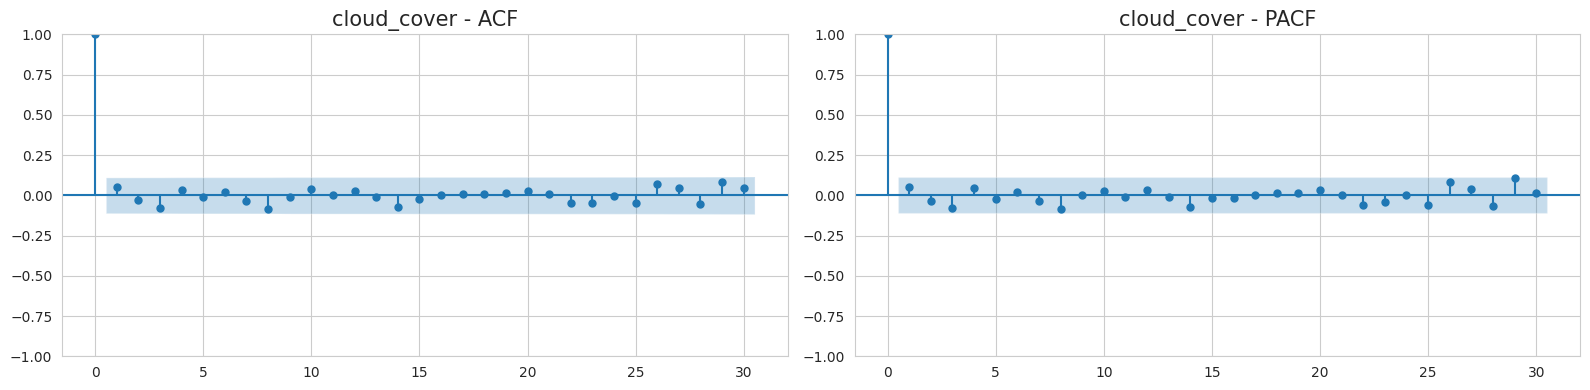

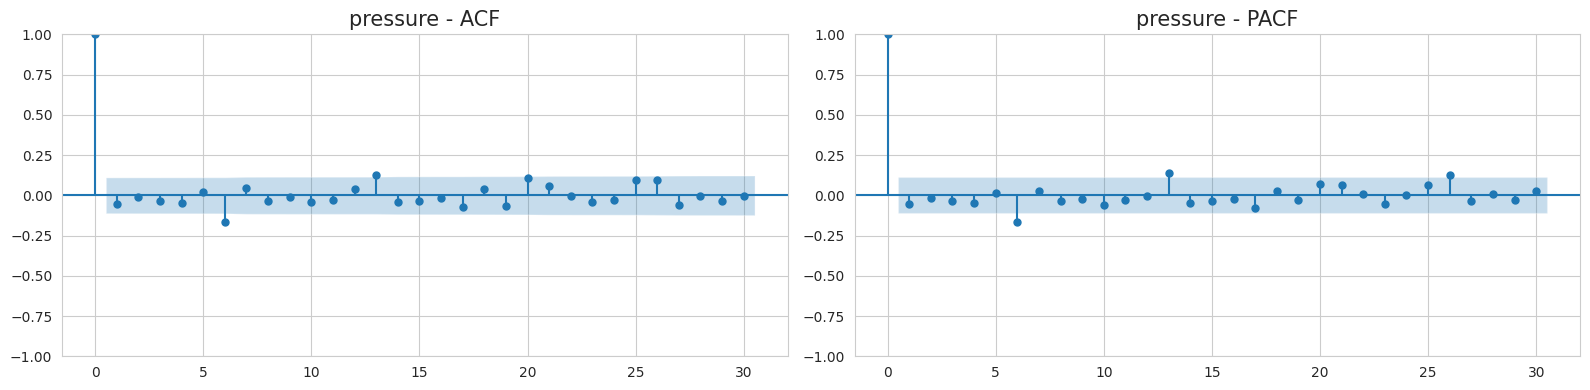

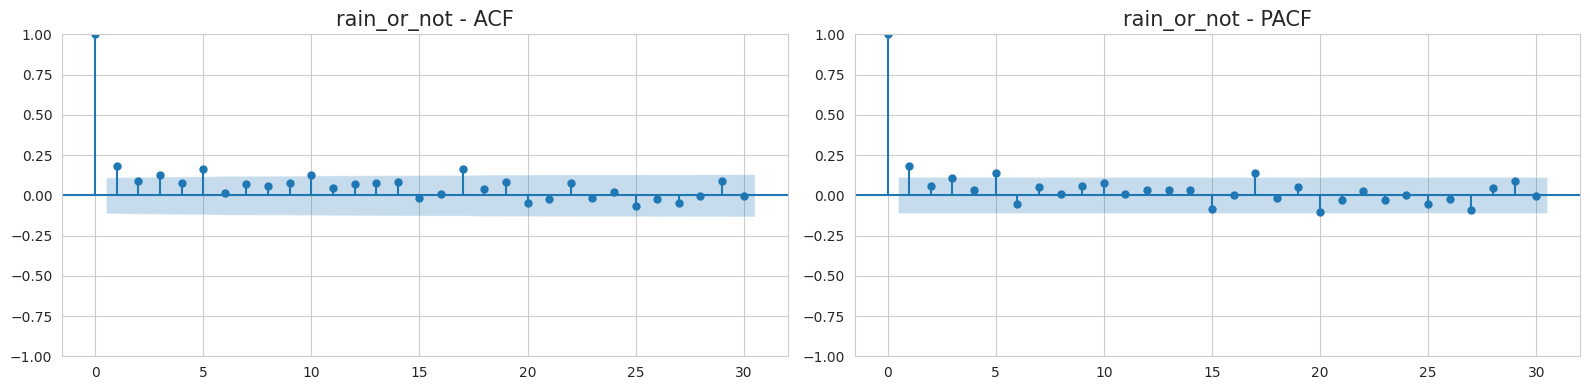

In [18]:
def plot_acf_pacf(data, title):
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))
    plot_acf(data, lags=30, ax=axes[0])
    axes[0].set_title(f'{title} - ACF', fontsize=15)
    plot_pacf(data, lags=30, ax=axes[1])
    axes[1].set_title(f'{title} - PACF', fontsize=15)
    plt.tight_layout()
    plt.show()

def make_stationary(data):
    result = adfuller(data)
    if result[1] > 0.05:
        data = data.diff().dropna()  # Detrend
    return data

numerical_features = numerical_variables + ['rain_or_not']

for feature in numerical_features:
    feature_data = weather[feature].copy() 
    stationary_feature_data = make_stationary(feature_data)
    plot_acf_pacf(stationary_feature_data, feature)

<Figure size 640x480 with 0 Axes>

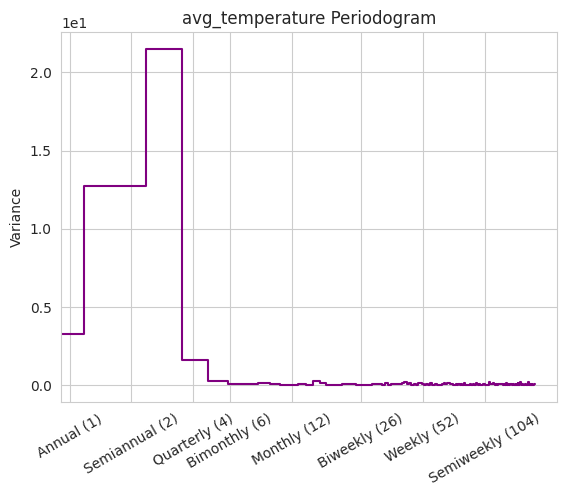

<Figure size 640x480 with 0 Axes>

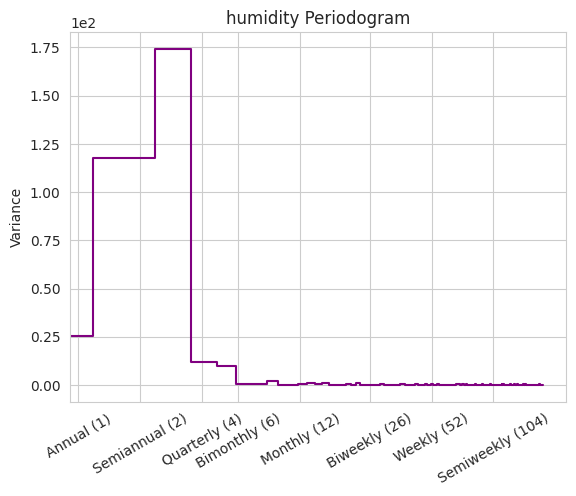

<Figure size 640x480 with 0 Axes>

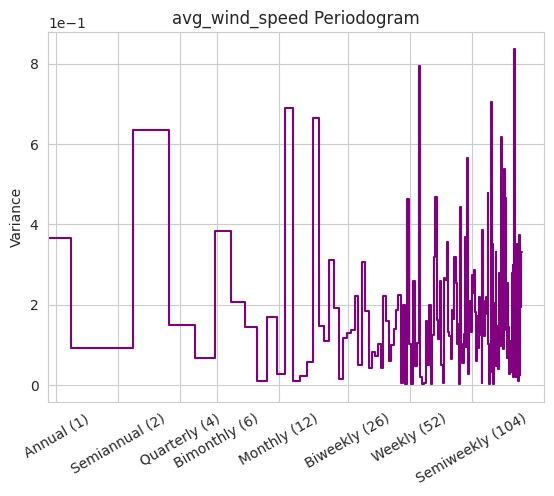

<Figure size 640x480 with 0 Axes>

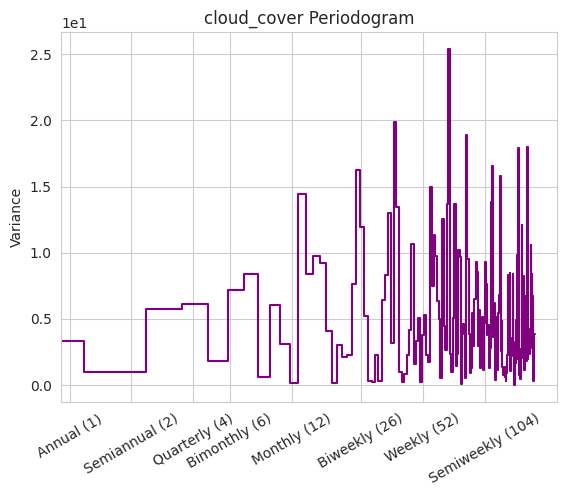

<Figure size 640x480 with 0 Axes>

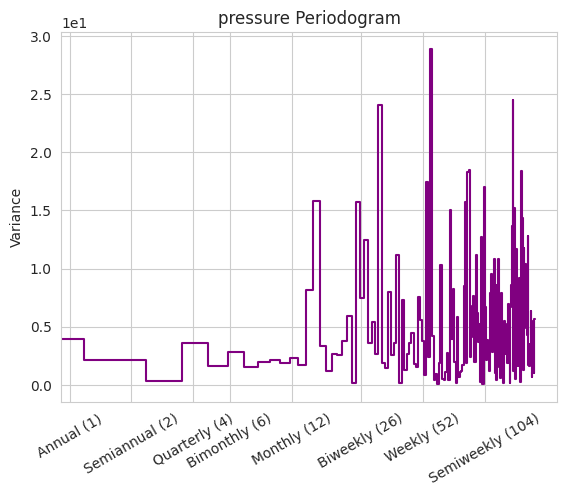

<Figure size 640x480 with 0 Axes>

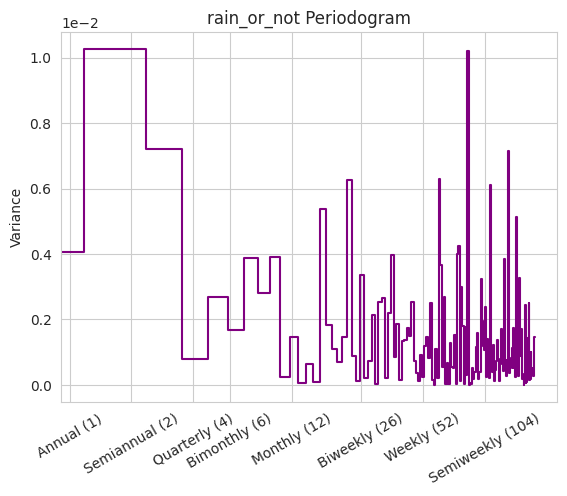

In [19]:
from learntools.time_series.utils import plot_periodogram

for feature in numerical_features:
    plt.figure()
    plot_periodogram(weather[feature])
    plt.title(f"{feature} Periodogram")
    plt.show()

In [20]:
weather

date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
0   2023-01-01        23.745401  46.140905        7.845981            1   
1   2023-01-02        30.030503  59.876587        5.382457            1   
2   2023-01-03        28.365224  51.464618       13.158008            1   
3   2023-01-04        27.550929  53.103799        5.886677            1   
4   2023-01-05        23.639303  57.826186       12.248992            1   
..         ...              ...        ...             ...          ...   
306 2023-11-03        22.072834  37.756910        4.729355            0   
307 2023-11-04        19.645885  42.190604        8.092369            0   
308 2023-11-05        23.884496  36.205508       11.860847            1   
309 2023-11-06        18.168418  34.785000        4.781288            0   
310 2023-11-07        19.389714  37.717416        9.388371            0   

     cloud_cover     pressure  
0      20.851051   992.965681  
1      93.059521  1037.273025  
2      11.636640  1034.193357  
3      81.744971   968.610142  
4      38.062329  1030.264331  
..           ...          ...  
306    27.307081   954.564875  
307    51.807877   964.002410  
308    29.872557   977.681431  
309    94.067925  1047.153269  
310    25.929676   983.134701  

[311 rows x 7 columns]

In [21]:
weather['month'] = weather['date'].dt.month
weather['day'] = weather['date'].dt.day

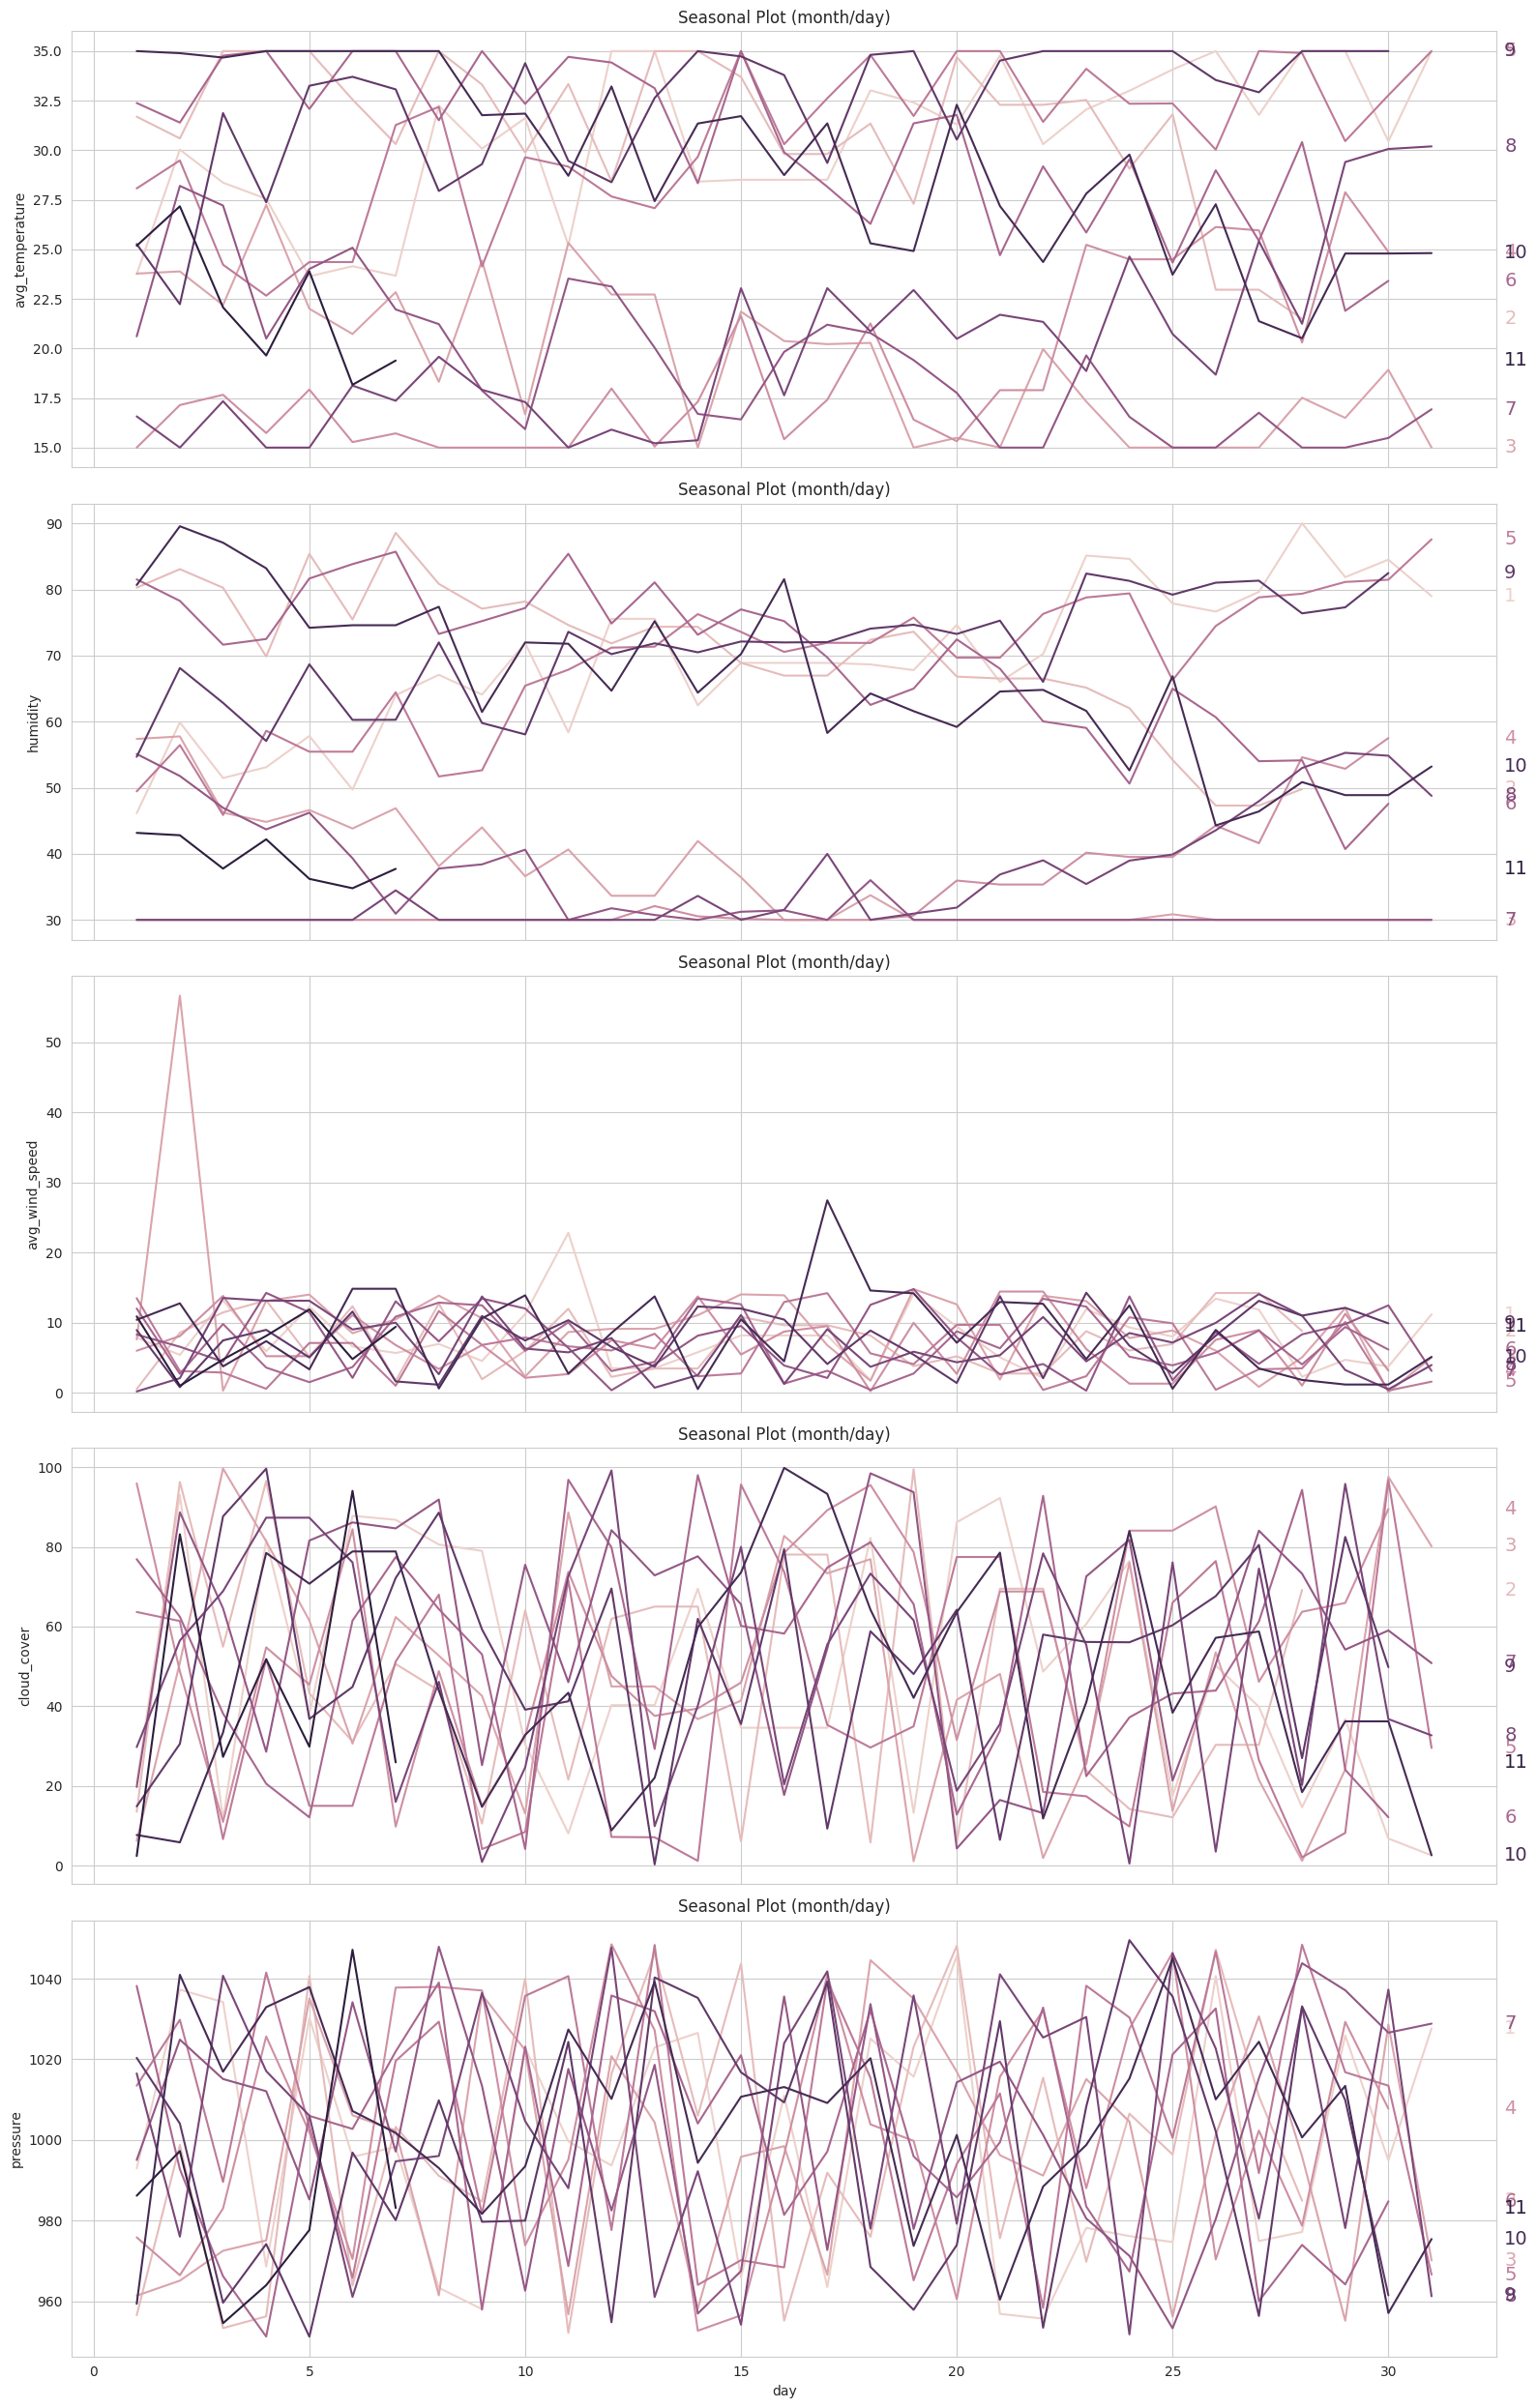

In [22]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,  # Pass full DataFrame, not Series
        ci=False,
        ax=ax,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

numerical_features = numerical_variables

fig, axes = plt.subplots(len(numerical_features), 1, figsize=(16, 5 * len(numerical_features)), sharex=True)

for feature, ax in zip(numerical_features, axes):
    seasonal_plot(weather, y=feature, period="month", freq="day", ax=ax)  

plt.tight_layout()
plt.show()


In [23]:
# weather.tail(21)

In [24]:
weather = weather.drop(columns=['month','day'])

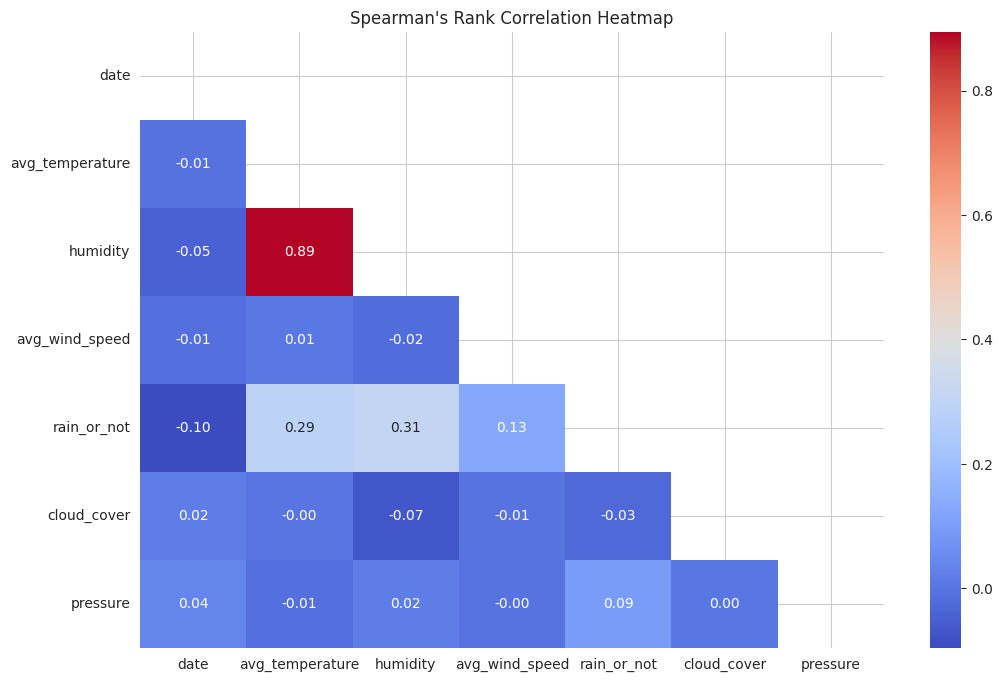

In [25]:
spearman_matrix = weather.corr(method="spearman")

mask = np.triu(np.ones_like(spearman_matrix, dtype=bool))

plt.figure(figsize=(12, 8))
sns.heatmap(spearman_matrix, annot=True, fmt=".2f", cmap="coolwarm", mask=mask)
plt.title("Spearman's Rank Correlation Heatmap")
plt.show()

In [26]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

avg_temperature    0.106731
humidity           0.084857
pressure           0.020196
avg_wind_speed     0.000000
cloud_cover        0.000000
Name: MI Scores, dtype: float64


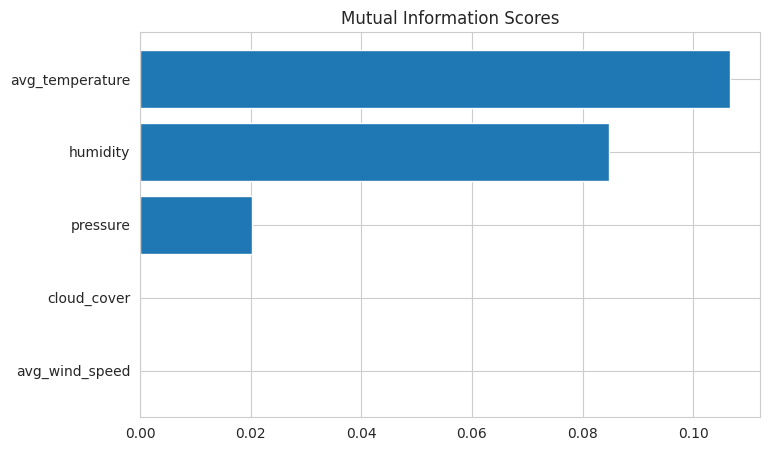

In [27]:
X = weather.drop(columns=['rain_or_not','date'], axis=1)  
y = weather['rain_or_not']

mi_scores = make_mi_scores(X, y)

print(mi_scores)
# print(mi_scores.tail(20))  

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
# plot_mi_scores(mi_scores.tail(20))  

In [28]:
train = weather[weather['date'] < '2023-10-18'].reset_index(drop=True)
test = weather[weather['date'] >= '2023-10-18'].reset_index(drop=True)

In [29]:
train

date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
0   2023-01-01        23.745401  46.140905        7.845981            1   
1   2023-01-02        30.030503  59.876587        5.382457            1   
2   2023-01-03        28.365224  51.464618       13.158008            1   
3   2023-01-04        27.550929  53.103799        5.886677            1   
4   2023-01-05        23.639303  57.826186       12.248992            1   
..         ...              ...        ...             ...          ...   
285 2023-10-13        27.430491  75.201885       13.732324            1   
286 2023-10-14        31.347286  64.378210        0.509190            1   
287 2023-10-15        31.719650  70.218325       10.461304            1   
288 2023-10-16        28.743265  81.552445        4.460235            0   
289 2023-10-17        31.354723  58.284143       27.430920            1   

     cloud_cover     pressure  
0      20.851051   992.965681  
1      93.059521  1037.273025  
2      11.636640  1034.193357  
3      81.744971   968.610142  
4      38.062329  1030.264331  
..           ...          ...  
285    22.061195  1039.252329  
286    59.822529   994.338001  
287    73.566311  1010.708958  
288    99.834751  1013.130755  
289    93.311333  1009.169716  

[290 rows x 7 columns]

In [30]:
test

date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
0  2023-10-18        25.305002  64.257243       14.565874            1   
1  2023-10-19        24.913387  61.582414       14.163997            1   
2  2023-10-20        32.293372  59.192256        7.113213            1   
3  2023-10-21        27.185586  64.552294       12.930640            0   
4  2023-10-22        24.360775  64.802155       12.668241            1   
5  2023-10-23        27.810623  61.622762        4.786507            1   
6  2023-10-24        29.779052  52.620655       12.433732            1   
7  2023-10-25        23.722555  66.862274        0.555115            0   
8  2023-10-26        27.274189  44.284638        8.944048            1   
9  2023-10-27        21.376834  46.406933        3.450133            1   
10 2023-10-28        20.516817  50.848646        1.808503            0   
11 2023-10-29        24.790187  48.876891        1.154298            1   
12 2023-10-30        24.790187  48.876891        1.154298            0   
13 2023-10-31        24.809954  53.207637        5.098124            0   
14 2023-11-01        25.181796  43.163395       10.871502            1   
15 2023-11-02        27.170330  42.804076        0.980345            0   
16 2023-11-03        22.072834  37.756910        4.729355            0   
17 2023-11-04        19.645885  42.190604        8.092369            0   
18 2023-11-05        23.884496  36.205508       11.860847            1   
19 2023-11-06        18.168418  34.785000        4.781288            0   
20 2023-11-07        19.389714  37.717416        9.388371            0   

    cloud_cover     pressure  
0     64.256520  1020.263377  
1     42.124805   973.743347  
2     63.617736  1001.236378  
3     78.565162   960.422480  
4     11.833619   988.451133  
5     40.990489   998.766707  
6     83.980229  1015.222426  
7     38.383295  1045.053105  
8     57.187227  1010.065107  
9     58.776936  1024.359392  
10    18.447625  1000.626606  
11    36.223544  1013.410403  
12    36.223544   957.093222  
13     2.619671   975.439158  
14     2.419176   986.185309  
15    83.169704   997.249336  
16    27.307081   954.564875  
17    51.807877   964.002410  
18    29.872557   977.681431  
19    94.067925  1047.153269  
20    25.929676   983.134701



----- Running ARIMA for feature: avg_temperature -----

ADF Statistic for avg_temperature: -2.4304417267495313
p-value for avg_temperature: 0.13332811973334302
Top parameter combinations based on AIC:
    p  d  q          aic          bic
14  0  2  4  1405.335301  1423.562536
29  1  2  4  1407.525744  1429.398425
44  2  2  4  1409.145857  1434.663986
13  0  2  3  1410.352920  1424.948817
39  2  1  4  1410.643371  1436.186191


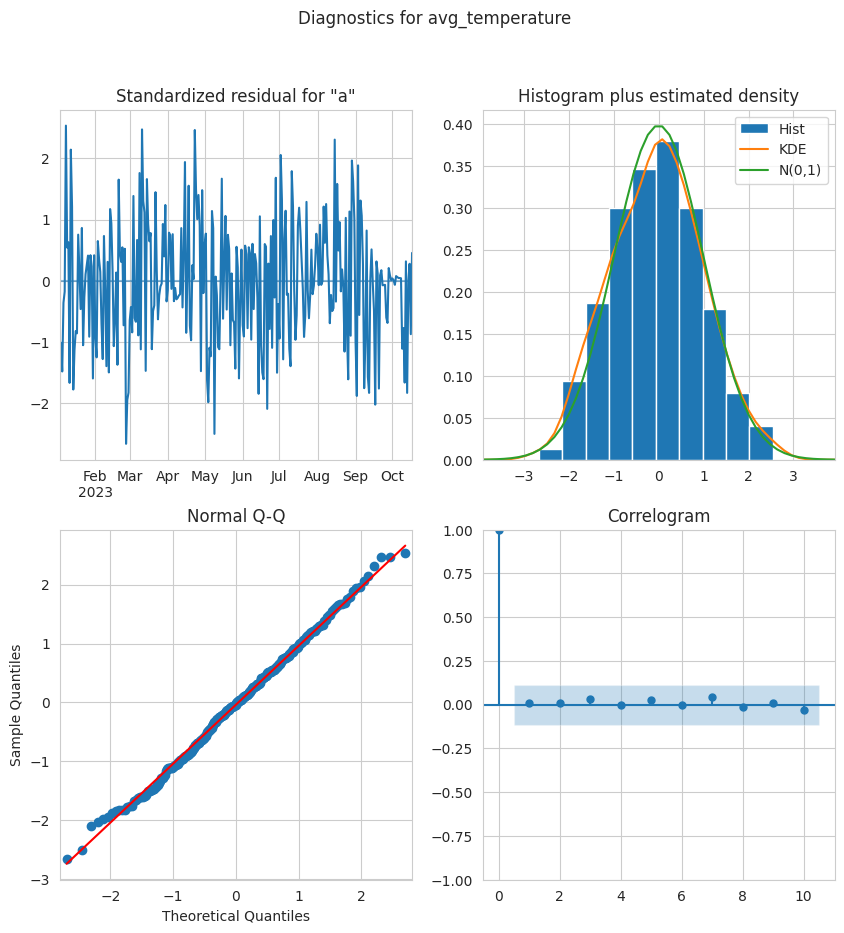


Results for avg_temperature:
Best parameters: p=0, d=2, q=4
RMSE: 2.859417079580808
MAE: 2.392525459835067
MAPE: 10.046300458304103%


----- Running ARIMA for feature: humidity -----

ADF Statistic for humidity: -3.946056926621681
p-value for humidity: 0.0017208611311330198
Top parameter combinations based on AIC:
    p  d  q          aic          bic
59  3  2  4  1733.910027  1763.073602
69  4  1  4  1736.372768  1769.213536
74  4  2  4  1736.597992  1769.407014
44  2  2  4  1736.967636  1762.485765
14  0  2  4  1742.239083  1760.466317


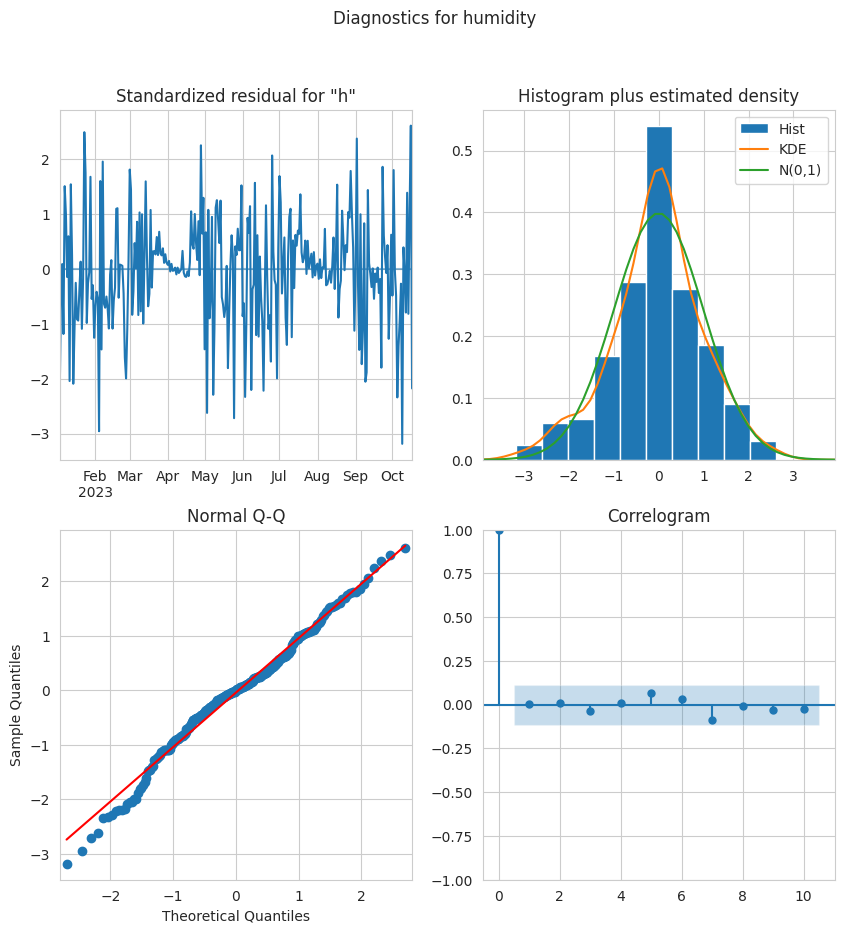


Results for humidity:
Best parameters: p=3, d=2, q=4
RMSE: 7.48566896371908
MAE: 6.234227944829298
MAPE: 14.05715904500687%


----- Running ARIMA for feature: avg_wind_speed -----

ADF Statistic for avg_wind_speed: -17.503007600268525
p-value for avg_wind_speed: 4.375312446683034e-30
Top parameter combinations based on AIC:
    p  d  q          aic          bic
69  4  1  4  1771.895132  1804.735900
24  1  1  4  1772.260642  1794.154487
9   0  1  4  1774.682738  1792.927609
54  3  1  4  1775.442734  1804.634528
53  3  1  3  1777.324477  1802.891901


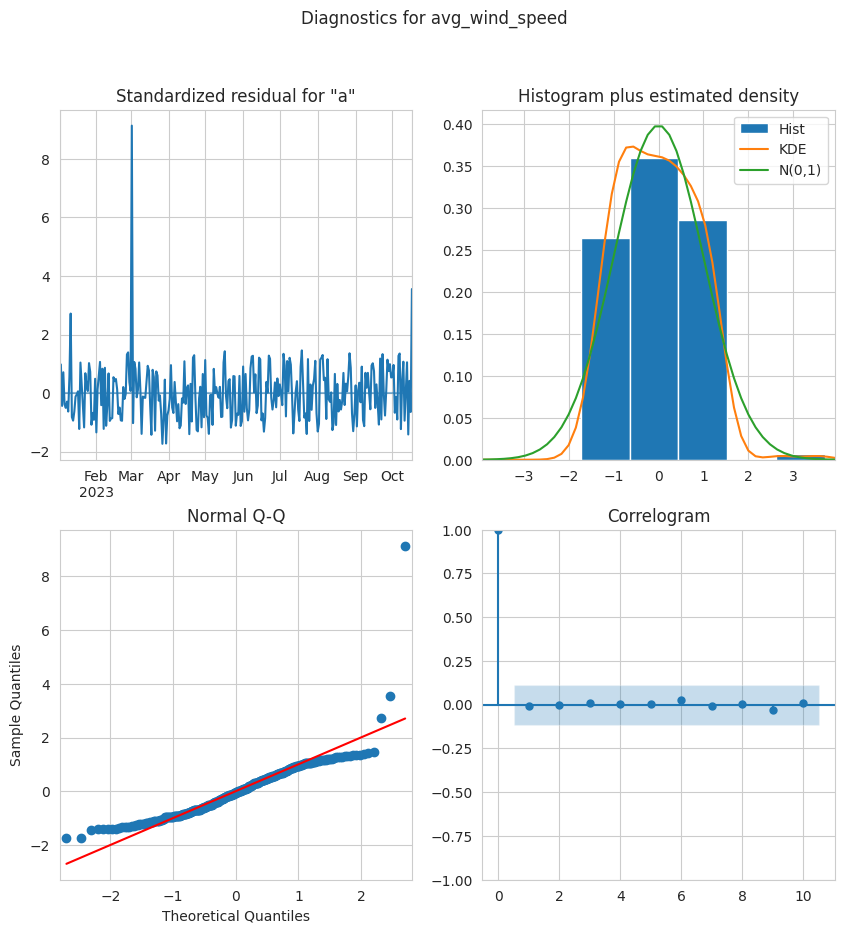


Results for avg_wind_speed:
Best parameters: p=4, d=1, q=4
RMSE: 5.004300908998337
MAE: 4.410429362540893
MAPE: 219.3789404140099%


----- Running ARIMA for feature: cloud_cover -----

ADF Statistic for cloud_cover: -15.849129567411712
p-value for cloud_cover: 9.494207741734895e-29
Top parameter combinations based on AIC:
    p  d  q          aic          bic
54  3  1  4  2718.373135  2747.564929
9   0  1  4  2724.054040  2742.298911
24  1  1  4  2725.842250  2747.736095
69  4  1  4  2725.978826  2758.819594
39  2  1  4  2727.685364  2753.228183


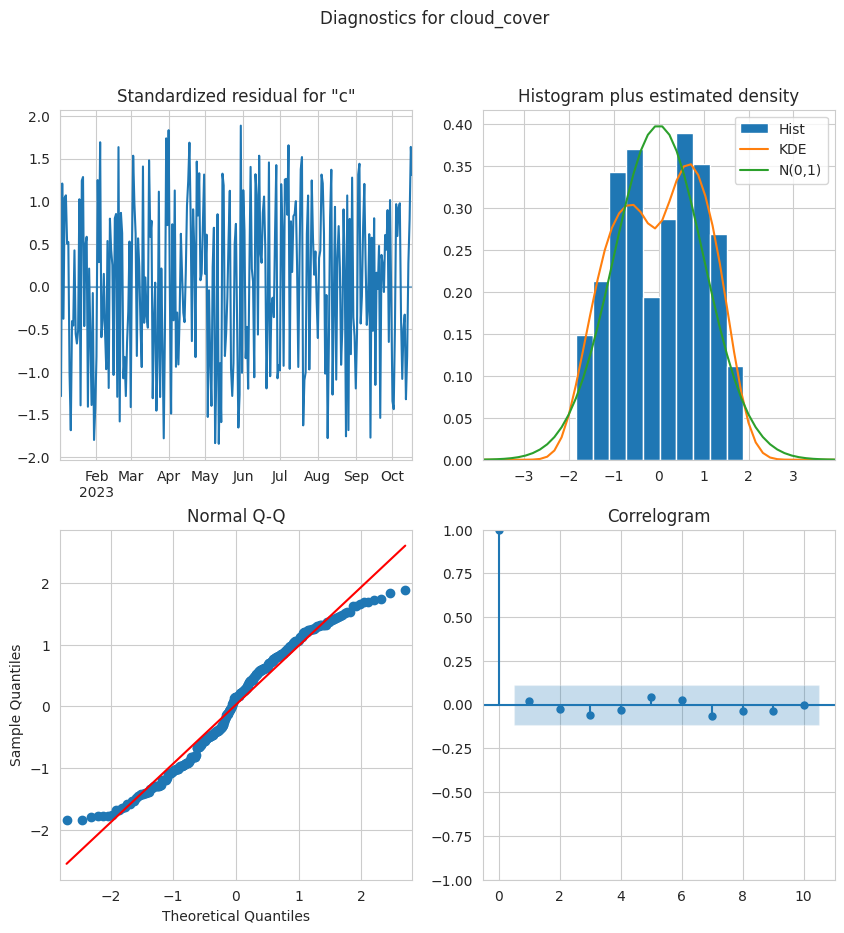


Results for cloud_cover:
Best parameters: p=3, d=1, q=4
RMSE: 26.41932086758694
MAE: 22.33370774643403
MAPE: 236.46574915148227%


----- Running ARIMA for feature: pressure -----

ADF Statistic for pressure: -18.246934013322566
p-value for pressure: 2.3477826075074635e-30
Top parameter combinations based on AIC:
    p  d  q          aic          bic
39  2  1  4  2727.933622  2753.476441
9   0  1  4  2730.371914  2748.616785
24  1  1  4  2732.047977  2753.941822
69  4  1  4  2732.377891  2765.218660
54  3  1  4  2733.629915  2762.821708


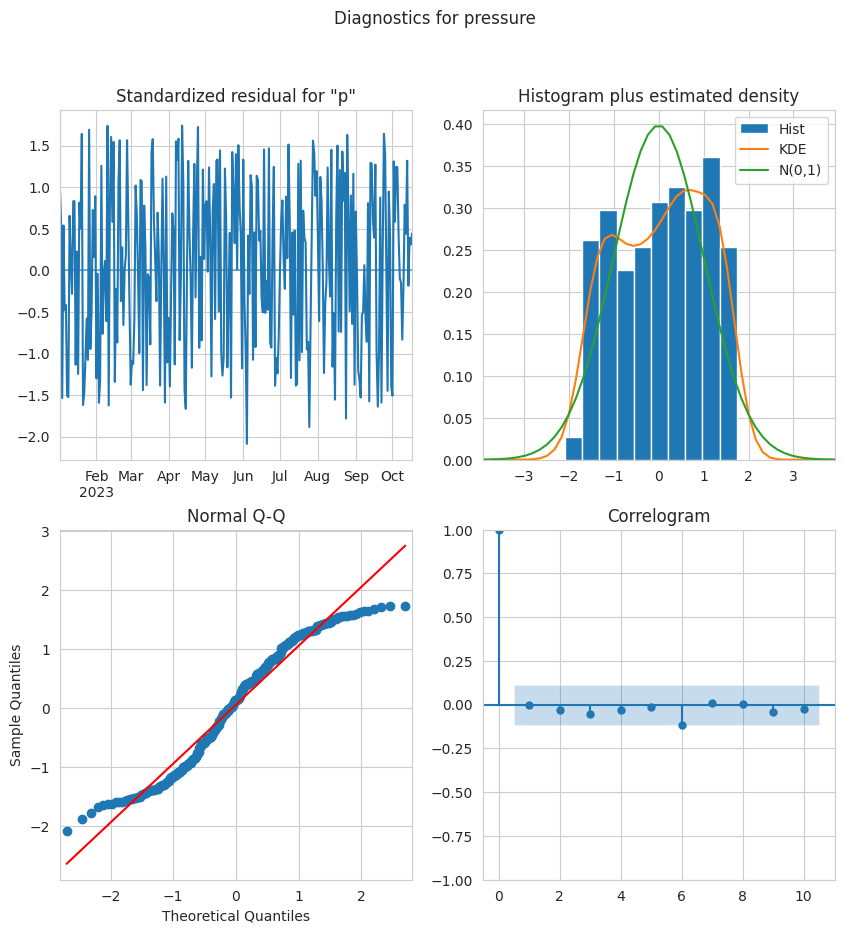


Results for pressure:
Best parameters: p=2, d=1, q=4
RMSE: 25.805347896208566
MAE: 21.346003961157823
MAPE: 2.1549969026043954%


feature  p  d  q       RMSE        MAE        MAPE
0  avg_temperature  0  2  4   2.859417   2.392525   10.046300
1         humidity  3  2  4   7.485669   6.234228   14.057159
2   avg_wind_speed  4  1  4   5.004301   4.410429  219.378940
3      cloud_cover  3  1  4  26.419321  22.333708  236.465749
4         pressure  2  1  4  25.805348  21.346004    2.154997

In [31]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def calculate_mape(actual, forecast):
    return np.mean(np.abs((actual - forecast) / actual)) * 100

# List of numerical features you want to forecast
numerical_features = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover', 'pressure']

# Initialize a list to store results for each feature
results_summary = []

# Create a DataFrame to store predictions with date as index
test_nw = test[['date']].copy()

for feature in numerical_features:
    print(f"\n\n----- Running ARIMA for feature: {feature} -----\n")
    
    # Subset train and test data for the current feature
    train_feature = train[['date', feature]].copy()
    test_feature = test[['date', feature]].copy()
    
    # Convert 'date' to datetime and set as index for training data
    train_feature['date'] = pd.to_datetime(train_feature['date'])
    train_feature.set_index('date', inplace=True)
    
    # ADF Test to check stationarity
    adf_result = sm.tsa.adfuller(train_feature[feature])
    print(f'ADF Statistic for {feature}: {adf_result[0]}')
    print(f'p-value for {feature}: {adf_result[1]}')
    
    # Grid search for best (p, d, q) parameters based on AIC
    order_results = []
    for p in range(5):
        for d in range(3):  # differencing order (typically 0 to 2)
            for q in range(5):
                try:
                    model = sm.tsa.statespace.SARIMAX(train_feature[feature],
                                                      order=(p, d, q),
                                                      enforce_stationarity=False,
                                                      enforce_invertibility=False)
                    results = model.fit(disp=False)
                    order_results.append((p, d, q, results.aic, results.bic))
                except Exception as e:
                    continue

    order_df = pd.DataFrame(order_results, columns=['p', 'd', 'q', 'aic', 'bic'])
    print("Top parameter combinations based on AIC:")
    print(order_df.sort_values('aic').head())
    
    # Select best parameters based on the lowest AIC
    best_model = order_df.loc[order_df['aic'].idxmin()]
    p, d, q = int(best_model['p']), int(best_model['d']), int(best_model['q'])
    
    # Enforce at least one differencing if series is non-stationary
    if adf_result[1] > 0.05 and d == 0:
        d = 1
    
    # Fit the final ARIMA model
    final_model = ARIMA(train_feature[feature], order=(p, d, q))
    final_fit = final_model.fit()
    # print(final_fit.summary())
    
    # Diagnostic plots
    final_fit.plot_diagnostics(figsize=(10, 10))
    plt.suptitle(f"Diagnostics for {feature}")
    plt.show()
    
    # Forecast on the test set period (assumes daily frequency)
    steps = len(test_feature)
    forecast = final_fit.forecast(steps=steps)
    
    # Evaluate the forecast
    actual = test_feature[feature].values
    rmse = np.sqrt(mean_squared_error(actual, forecast))
    mae = mean_absolute_error(actual, forecast)
    mape = calculate_mape(actual, forecast)
    
    print(f"\nResults for {feature}:")
    print(f"Best parameters: p={p}, d={d}, q={q}")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}%")
    
    # Append results to the summary list
    results_summary.append({
        'feature': feature,
        'p': p,
        'd': d,
        'q': q,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    })
    
    test_nw[feature] = forecast.values

results_df = pd.DataFrame(results_summary)
results_df

In [32]:
test_nw

date  avg_temperature   humidity  avg_wind_speed  cloud_cover  \
0  2023-10-18        29.903836  65.325401        7.330556    51.869288   
1  2023-10-19        29.638994  64.343175        7.251514    48.249465   
2  2023-10-20        29.040401  61.683434        9.108823    52.034127   
3  2023-10-21        28.569629  64.503492        8.704504    50.660806   
4  2023-10-22        28.098858  59.328338        8.561310    49.034630   
5  2023-10-23        27.628086  61.356089        8.143516    52.028257   
6  2023-10-24        27.157315  59.579875        8.923400    50.120608   
7  2023-10-25        26.686543  56.960809        8.613066    49.524455   
8  2023-10-26        26.215772  59.270692        8.273235    52.081444   
9  2023-10-27        25.745000  54.619180        8.648301    49.481740   
10 2023-10-28        25.274228  56.257418        8.737725    50.355318   
11 2023-10-29        24.803457  54.588596        8.384950    51.560299   
12 2023-10-30        24.332685  52.167503        8.508332    49.457865   
13 2023-10-31        23.861914  54.063590        8.716758    50.748305   
14 2023-11-01        23.391142  49.875883        8.509707    51.218050   
15 2023-11-02        22.920370  51.175950        8.456366    49.413205   
16 2023-11-03        22.449599  49.600122        8.647489    51.197386   
17 2023-11-04        21.978827  47.352992        8.587098    50.646882   
18 2023-11-05        21.508056  48.887117        8.469518    49.758438   
19 2023-11-06        21.037284  45.104438        8.579683    51.232988   
20 2023-11-07        20.566513  46.109777        8.613050    50.362249   

       pressure  
0   1005.927020  
1    995.796305  
2   1007.300110  
3    995.969079  
4   1006.499223  
5    997.334840  
6   1004.661532  
7    999.527879  
8   1002.246152  
9   1002.024082  
10   999.810996  
11  1004.263906  
12   997.885922  
13  1005.775917  
14   996.859312  
15  1006.274041  
16   996.901957  
17  1005.708924  
18   997.942593  
19  1004.264915  
20   999.697409

In [35]:
train

date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
0   2023-01-01        23.745401  46.140905        7.845981            1   
1   2023-01-02        30.030503  59.876587        5.382457            1   
2   2023-01-03        28.365224  51.464618       13.158008            1   
3   2023-01-04        27.550929  53.103799        5.886677            1   
4   2023-01-05        23.639303  57.826186       12.248992            1   
..         ...              ...        ...             ...          ...   
285 2023-10-13        27.430491  75.201885       13.732324            1   
286 2023-10-14        31.347286  64.378210        0.509190            1   
287 2023-10-15        31.719650  70.218325       10.461304            1   
288 2023-10-16        28.743265  81.552445        4.460235            0   
289 2023-10-17        31.354723  58.284143       27.430920            1   

     cloud_cover     pressure  
0      20.851051   992.965681  
1      93.059521  1037.273025  
2      11.636640  1034.193357  
3      81.744971   968.610142  
4      38.062329  1030.264331  
..           ...          ...  
285    22.061195  1039.252329  
286    59.822529   994.338001  
287    73.566311  1010.708958  
288    99.834751  1013.130755  
289    93.311333  1009.169716  

[290 rows x 7 columns]

In [36]:
val = test['rain_or_not']

In [39]:
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
test_nw['month'] = test_nw['date'].dt.month
test_nw['day'] = test_nw['date'].dt.day

In [40]:
train["cloud_windspeed"] = train["cloud_cover"] * train["avg_wind_speed"]
train['wind_temp_interaction'] = train['avg_wind_speed'] * train['avg_temperature']
train['season'] = train['month'].apply(lambda x: 1 if 3 <= x <= 5  
                                         else 2 if 6 <= x <= 8  
                                         else 3 if 9 <= x <= 11  
                                         else 0)  
train['season_cloud_trend'] = train['cloud_cover'] * train['season']

In [43]:
test_nw["cloud_windspeed"] = test_nw["cloud_cover"] * test_nw["avg_wind_speed"]
test_nw['wind_temp_interaction'] = test_nw['avg_wind_speed'] * test_nw['avg_temperature']
test_nw['season'] = test_nw['month'].apply(lambda x: 1 if 3 <= x <= 5  
                                         else 2 if 6 <= x <= 8  
                                         else 3 if 9 <= x <= 11  
                                         else 0)  
test_nw['season_cloud_trend'] = test_nw['cloud_cover'] * test_nw['season']

humidity                 0.102553
month                    0.088398
season_cloud_trend       0.071340
avg_temperature          0.062516
season                   0.061623
pressure                 0.038618
cloud_windspeed          0.009614
avg_wind_speed           0.000000
cloud_cover              0.000000
wind_temp_interaction    0.000000
day                      0.000000
Name: MI Scores, dtype: float64


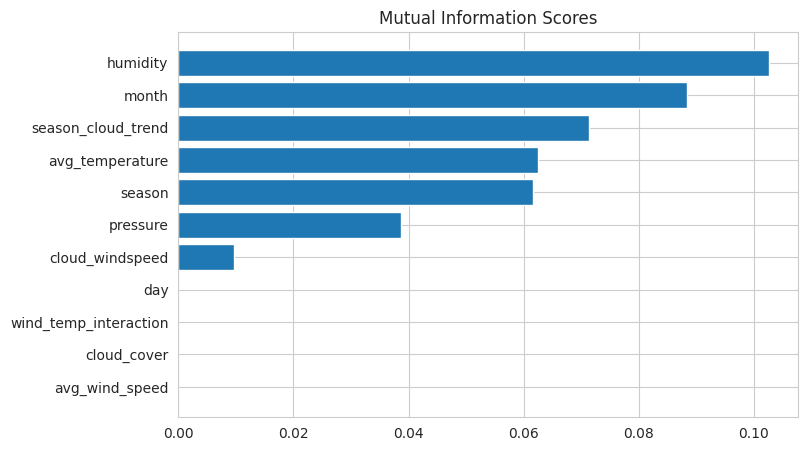

In [45]:
X = train.drop(columns=['rain_or_not','date'], axis=1)  
y = train['rain_or_not']

mi_scores = make_mi_scores(X, y)

print(mi_scores)
# print(mi_scores.tail(20))  

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)
# plot_mi_scores(mi_scores.tail(20))  

In [46]:
train = train.drop(columns=['month','day','wind_temp_interaction','avg_wind_speed','cloud_cover','date'])
test_nw = test_nw.drop(columns=['month','day','wind_temp_interaction','avg_wind_speed','cloud_cover','date'])

In [60]:
train

date  avg_temperature   humidity  rain_or_not     pressure  \
0   2023-01-01        23.745401  46.140905            1   992.965681   
1   2023-01-02        30.030503  59.876587            1  1037.273025   
2   2023-01-03        28.365224  51.464618            1  1034.193357   
3   2023-01-04        27.550929  53.103799            1   968.610142   
4   2023-01-05        23.639303  57.826186            1  1030.264331   
..         ...              ...        ...          ...          ...   
285 2023-10-13        27.430491  75.201885            1  1039.252329   
286 2023-10-14        31.347286  64.378210            1   994.338001   
287 2023-10-15        31.719650  70.218325            1  1010.708958   
288 2023-10-16        28.743265  81.552445            0  1013.130755   
289 2023-10-17        31.354723  58.284143            1  1009.169716   

     cloud_windspeed  season  season_cloud_trend  
0         163.596961       0            0.000000  
1         500.888897       0            0.000000  
2         153.115001       0            0.000000  
3         481.206208       0            0.000000  
4         466.225152       0            0.000000  
..               ...     ...                 ...  
285       302.951492       3           66.183586  
286        30.461015       3          179.467588  
287       769.599549       3          220.698934  
288       445.286462       3          299.504253  
289      2559.615734       3          279.933999  

[290 rows x 8 columns]

In [61]:
test_nw

date  avg_temperature   humidity     pressure  cloud_windspeed  \
0  2023-10-18        29.903836  65.325401  1005.927020       380.230734   
1  2023-10-19        29.638994  64.343175   995.796305       349.881669   
2  2023-10-20        29.040401  61.683434  1007.300110       473.969666   
3  2023-10-21        28.569629  64.503492   995.969079       440.977183   
4  2023-10-22        28.098858  59.328338  1006.499223       419.800651   
5  2023-10-23        27.628086  61.356089   997.334840       423.692917   
6  2023-10-24        27.157315  59.579875  1004.661532       447.246224   
7  2023-10-25        26.686543  56.960809   999.527879       426.557401   
8  2023-10-26        26.215772  59.270692  1002.246152       430.882029   
9  2023-10-27        25.745000  54.619180  1002.024082       427.932964   
10 2023-10-28        25.274228  56.257418   999.810996       439.990934   
11 2023-10-29        24.803457  54.588596  1004.263906       432.330521   
12 2023-10-30        24.332685  52.167503   997.885922       420.803913   
13 2023-10-31        23.861914  54.063590  1005.775917       442.360709   
14 2023-11-01        23.391142  49.875883   996.859312       435.850585   
15 2023-11-02        22.920370  51.175950  1006.274041       417.856163   
16 2023-11-03        22.449599  49.600122   996.901957       442.728809   
17 2023-11-04        21.978827  47.352992  1005.708924       434.909742   
18 2023-11-05        21.508056  48.887117   997.942593       421.429988   
19 2023-11-06        21.037284  45.104438  1004.264915       439.562790   
20 2023-11-07        20.566513  46.109777   999.697409       433.772547   

    season  season_cloud_trend  
0        3          155.607863  
1        3          144.748396  
2        3          156.102382  
3        3          151.982418  
4        3          147.103890  
5        3          156.084771  
6        3          150.361824  
7        3          148.573366  
8        3          156.244331  
9        3          148.445219  
10       3          151.065953  
11       3          154.680898  
12       3          148.373595  
13       3          152.244916  
14       3          153.654151  
15       3          148.239614  
16       3          153.592158  
17       3          151.940646  
18       3          149.275313  
19       3          153.698964  
20       3          151.086747

In [50]:
import numpy as np
import pandas as pd
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score

def get_model_predictions(X, y, df_test, model_func, params, cat_features_indices=None):
    test_preds = np.zeros(len(df_test))
    val_preds = np.zeros(len(X))
    
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42) 
    
    feature_importances = pd.DataFrame(index=X.columns)

    for fold, (train_ind, valid_ind) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_ind], y[train_ind]
        X_val, y_val = X.iloc[valid_ind], y[valid_ind]
            
        model = model_func(**params)
        if model_func == lgb_model:
            model.fit(X_train, y_train,
                      eval_set=[(X_val, y_val)],
                      callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)])
            fold_importance = pd.Series(model.feature_importances_, index=X_train.columns)
            
        elif model_func == xgb_model:
            model.fit(X_train, y_train,
                      eval_set=[(X_val, y_val)],
                      early_stopping_rounds=50,
                      verbose=False)
            fold_importance = pd.Series(model.feature_importances_, index=X_train.columns)
            
        else:
            model.fit(X_train, y_train,
                      cat_features=cat_features_indices,
                      eval_set=[(X_val, y_val)],
                      early_stopping_rounds=200,
                      verbose=False)
            fold_importance = pd.Series(model.feature_importances_, index=X_train.columns)
        
        gc.collect()

        # Predictions on training and validation sets
        y_pred_trn = model.predict(X_train)
        y_pred_val = model.predict(X_val)

        # Calculate Accuracy and F1 score
        train_acc = accuracy_score(y_train, y_pred_trn)
        val_acc = accuracy_score(y_val, y_pred_val)
        train_f1 = f1_score(y_train, y_pred_trn, average='weighted')
        val_f1 = f1_score(y_val, y_pred_val, average='weighted')

        print("-" * 50)
        print(f"{model_func.__name__} Fold {fold+1} | Train ACC: {np.round(train_acc, 5)} | Val ACC: {np.round(val_acc, 5)}")
        print(f"{model_func.__name__} Fold {fold+1} | Train F1: {np.round(train_f1, 5)}  | Val F1: {np.round(val_f1, 5)}")
        print("-" * 50)

        val_preds[valid_ind] = y_pred_val
        test_preds += model.predict(df_test) / cv.n_splits
        
        # Store feature importance
        if fold_importance is not None:
            feature_importances[f'fold_{fold+1}'] = fold_importance

        gc.collect()
    
    # Aggregate feature importances
    if not feature_importances.empty:
        feature_importances['mean_importance'] = feature_importances.mean(axis=1)
        feature_importances = feature_importances.sort_values(by="mean_importance", ascending=False)
        print("Feature Importances:\n", feature_importances['mean_importance'])
    
    return val_preds, test_preds

In [51]:
def lgb_model(**params):
    return lgb.LGBMClassifier(**params)

def xgb_model(**params):
    return XGBClassifier(**params)

def catb_model(**params):
    return CatBoostClassifier(**params)

In [69]:
label = 'rain_or_not' 
X = train.drop(columns=[label], axis=1)  
y = train[label]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
test_nw = test_nw.reset_index(drop=True)

In [77]:
train

avg_temperature   humidity  rain_or_not     pressure  cloud_windspeed  \
0          23.745401  46.140905            1   992.965681       163.596961   
1          30.030503  59.876587            1  1037.273025       500.888897   
2          28.365224  51.464618            1  1034.193357       153.115001   
3          27.550929  53.103799            1   968.610142       481.206208   
4          23.639303  57.826186            1  1030.264331       466.225152   
..               ...        ...          ...          ...              ...   
285        27.430491  75.201885            1  1039.252329       302.951492   
286        31.347286  64.378210            1   994.338001        30.461015   
287        31.719650  70.218325            1  1010.708958       769.599549   
288        28.743265  81.552445            0  1013.130755       445.286462   
289        31.354723  58.284143            1  1009.169716      2559.615734   

     season  season_cloud_trend  
0         0            0.000000  
1         0            0.000000  
2         0            0.000000  
3         0            0.000000  
4         0            0.000000  
..      ...                 ...  
285       3           66.183586  
286       3          179.467588  
287       3          220.698934  
288       3          299.504253  
289       3          279.933999  

[290 rows x 7 columns]

In [76]:
test_nw

avg_temperature   humidity     pressure  cloud_windspeed  season  \
0         29.903836  65.325401  1005.927020       380.230734       3   
1         29.638994  64.343175   995.796305       349.881669       3   
2         29.040401  61.683434  1007.300110       473.969666       3   
3         28.569629  64.503492   995.969079       440.977183       3   
4         28.098858  59.328338  1006.499223       419.800651       3   
5         27.628086  61.356089   997.334840       423.692917       3   
6         27.157315  59.579875  1004.661532       447.246224       3   
7         26.686543  56.960809   999.527879       426.557401       3   
8         26.215772  59.270692  1002.246152       430.882029       3   
9         25.745000  54.619180  1002.024082       427.932964       3   
10        25.274228  56.257418   999.810996       439.990934       3   
11        24.803457  54.588596  1004.263906       432.330521       3   
12        24.332685  52.167503   997.885922       420.803913       3   
13        23.861914  54.063590  1005.775917       442.360709       3   
14        23.391142  49.875883   996.859312       435.850585       3   
15        22.920370  51.175950  1006.274041       417.856163       3   
16        22.449599  49.600122   996.901957       442.728809       3   
17        21.978827  47.352992  1005.708924       434.909742       3   
18        21.508056  48.887117   997.942593       421.429988       3   
19        21.037284  45.104438  1004.264915       439.562790       3   
20        20.566513  46.109777   999.697409       433.772547       3   

    season_cloud_trend  
0           155.607863  
1           144.748396  
2           156.102382  
3           151.982418  
4           147.103890  
5           156.084771  
6           150.361824  
7           148.573366  
8           156.244331  
9           148.445219  
10          151.065953  
11          154.680898  
12          148.373595  
13          152.244916  
14          153.654151  
15          148.239614  
16          153.592158  
17          151.940646  
18          149.275313  
19          153.698964  
20          151.086747

In [78]:
lgb_params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'verbose':-1,
    'enable_categorical': True,
    'learning_rate': 0.01,
    'n_estimators': 1000
}

xgb_params = {
    'verbosity': 0,
    'learning_rate': 0.01,
    'n_estimators': 1000
}

catboost_params = {
    'loss_function': 'Logloss',
    'learning_rate': 0.01,
    'iterations': 1000
}

In [79]:
print("1. LGBMClassifier")
lgb_val_preds, lgb_test_preds = get_model_predictions(X, y, test_nw, lgb_model,lgb_params)

1. LGBMClassifier
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.344828
--------------------------------------------------
lgb_model Fold 1 | Train ACC: 0.64368 | Val ACC: 0.65517
lgb_model Fold 1 | Train F1: 0.50414  | Val F1: 0.51868
--------------------------------------------------
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.344828
--------------------------------------------------
lgb_model Fold 2 | Train ACC: 0.64368 | Val ACC: 0.65517
lgb_model Fold 2 | Train F1: 0.50414  | Val F1: 0.51868
--------------------------------------------------
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1]	valid_0's binary_error: 0.344828
--------------------------------------------------
lgb_model Fold 3 | Train ACC: 0.64368 | Val ACC: 0.65517
lgb_model Fold 3 | Train F1: 0.50414  | Val F

In [80]:
print("2. XGBClassifier")
xgb_val_preds, xgb_test_preds = get_model_predictions(X, y, test_nw, xgb_model,xgb_params)

2. XGBClassifier
--------------------------------------------------
xgb_model Fold 1 | Train ACC: 0.65517 | Val ACC: 0.65517
xgb_model Fold 1 | Train F1: 0.52996  | Val F1: 0.51868
--------------------------------------------------
--------------------------------------------------
xgb_model Fold 2 | Train ACC: 0.64368 | Val ACC: 0.65517
xgb_model Fold 2 | Train F1: 0.50414  | Val F1: 0.51868
--------------------------------------------------
--------------------------------------------------
xgb_model Fold 3 | Train ACC: 0.88506 | Val ACC: 0.68966
xgb_model Fold 3 | Train F1: 0.87872  | Val F1: 0.65597
--------------------------------------------------
--------------------------------------------------
xgb_model Fold 4 | Train ACC: 0.64368 | Val ACC: 0.65517
xgb_model Fold 4 | Train F1: 0.50414  | Val F1: 0.51868
--------------------------------------------------
--------------------------------------------------
xgb_model Fold 5 | Train ACC: 0.64368 | Val ACC: 0.65517
xgb_model Fold 

In [83]:
print("3. CatBoostClassifier")
catb_val_preds, catb_test_preds = get_model_predictions(X, y, test_nw, catb_model,catboost_params, [4])

3. CatBoostClassifier
--------------------------------------------------
catb_model Fold 1 | Train ACC: 0.7931 | Val ACC: 0.65517
catb_model Fold 1 | Train F1: 0.78645  | Val F1: 0.64464
--------------------------------------------------
--------------------------------------------------
catb_model Fold 2 | Train ACC: 0.77011 | Val ACC: 0.72414
catb_model Fold 2 | Train F1: 0.76452  | Val F1: 0.70279
--------------------------------------------------
--------------------------------------------------
catb_model Fold 3 | Train ACC: 0.85824 | Val ACC: 0.75862
catb_model Fold 3 | Train F1: 0.85732  | Val F1: 0.74615
--------------------------------------------------
--------------------------------------------------
catb_model Fold 4 | Train ACC: 0.94636 | Val ACC: 0.65517
catb_model Fold 4 | Train F1: 0.94594  | Val F1: 0.64464
--------------------------------------------------
--------------------------------------------------
catb_model Fold 5 | Train ACC: 0.77395 | Val ACC: 0.68966
ca

In [89]:
X.to_csv("X.csv", index=False)
y.to_csv("y.csv", index=False)

## Hyperparameter tuning

In [90]:
# import optuna
# import numpy as np
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import accuracy_score
# from catboost import CatBoostClassifier

# def optimize_catboost(trial):
#     param = {
#         'depth': trial.suggest_int('depth', 4, 16),
#         'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
#         'iterations': trial.suggest_int('iterations', 500, 8000),
#         'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
#         'loss_function': 'Logloss',
#         'random_seed': 42,
#         'verbose': 0,
#         'task_type': 'GPU' if CatBoostClassifier().get_param('task_type') == 'GPU' else 'CPU',
#     }

#     cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#     scores = []

#     for train_idx, valid_idx in cv.split(X, y):
#         X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
#         y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

#         model = CatBoostClassifier(**param)
#         model.fit(
#             X_train, y_train,
#             cat_features=[4],
#             eval_set=(X_valid, y_valid),
#             early_stopping_rounds=100,
#             verbose=False
#         )
#         preds = model.predict(X_valid)
#         scores.append(f1_score(y_valid, preds)) 

#     return np.mean(scores)

# # Run optimization
# study_catboost = optuna.create_study(direction='maximize')
# study_catboost.optimize(optimize_catboost, n_trials=50)

# # Print best parameters and accuracy
# print("Best CatBoost Params:", study_catboost.best_params)
# print("Best CatBoost Accuracy:", study_catboost.best_value)

In [91]:
catboost_params_ = {
    'loss_function': 'Logloss',
    'learning_rate': 0.0010315109107573211,
    'iterations': 3815,
    'depth': 12,
    'l2_leaf_reg': 0.2798659581346516
}

In [92]:
print("3. CatBoostClassifier")
catb_val_preds, catb_test_preds = get_model_predictions(X, y, test_nw, catb_model,catboost_params, [4])

3. CatBoostClassifier
--------------------------------------------------
catb_model Fold 1 | Train ACC: 0.93487 | Val ACC: 0.68966
catb_model Fold 1 | Train F1: 0.93363  | Val F1: 0.67363
--------------------------------------------------
--------------------------------------------------
catb_model Fold 2 | Train ACC: 0.92337 | Val ACC: 0.72414
catb_model Fold 2 | Train F1: 0.92254  | Val F1: 0.70279
--------------------------------------------------
--------------------------------------------------
catb_model Fold 3 | Train ACC: 0.95402 | Val ACC: 0.68966
catb_model Fold 3 | Train F1: 0.95391  | Val F1: 0.68547
--------------------------------------------------
--------------------------------------------------
catb_model Fold 4 | Train ACC: 0.91188 | Val ACC: 0.62069
catb_model Fold 4 | Train F1: 0.91079  | Val F1: 0.6011
--------------------------------------------------
--------------------------------------------------
catb_model Fold 5 | Train ACC: 0.9387 | Val ACC: 0.72414
cat

--------------------------------------------------
********************
Validation ACC       : 0.67586
Validation Recall    : 82.89 %
Validation F1 Score  : 76.73 %
Validation Precision : 71.43 %
********************


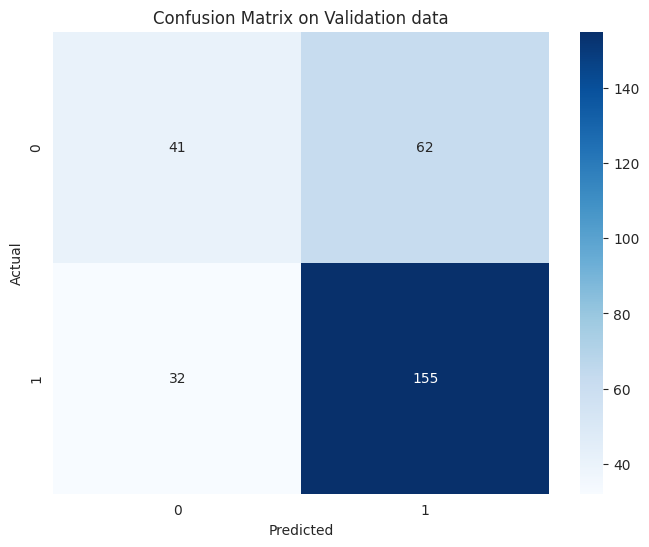

--------------------------------------------------


In [103]:
acc = np.round(accuracy_score(y, catb_val_preds), 5)
recall = np.round(recall_score(y, catb_val_preds) * 100, 2)
f1 = np.round(f1_score(y, catb_val_preds) * 100, 2)
precision = np.round(precision_score(y, catb_val_preds) * 100, 2)
print("-" * 50)

print('*' * 20)
print('Validation ACC       :', acc)
print('Validation Recall    :', recall, '%')
print('Validation F1 Score  :', f1, '%')
print('Validation Precision :', precision, '%')
print('*' * 20)

# Draw the confusion matrix
cm = confusion_matrix(y, catb_val_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix on Validation data')
plt.show()
gc.collect()

print("-" * 50)

--------------------------------------------------
********************
Prediction ACC       : 0.71429
Prediction Recall    : 54.55 %
Prediction F1 Score  : 66.67 %
Prediction Precision : 85.71 %
********************


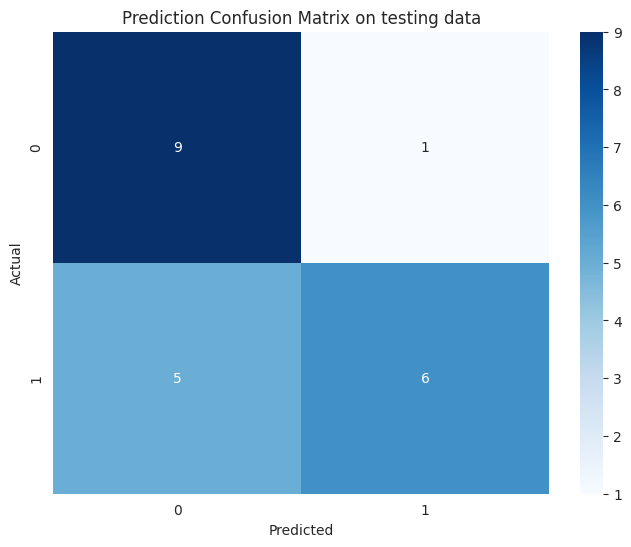

--------------------------------------------------


In [104]:
acc = np.round(accuracy_score(val, catb_test_preds.round()), 5)
recall = np.round(recall_score(val, catb_test_preds.round()) * 100, 2)
f1 = np.round(f1_score(val, catb_test_preds.round()) * 100, 2)
precision = np.round(precision_score(val, catb_test_preds.round()) * 100, 2)
print("-" * 50)

print('*' * 20)
print('Prediction ACC       :', acc)
print('Prediction Recall    :', recall, '%')
print('Prediction F1 Score  :', f1, '%')
print('Prediction Precision :', precision, '%')
print('*' * 20)

# Draw the confusion matrix
cm = confusion_matrix(val, catb_test_preds.round())
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Prediction Confusion Matrix on testing data')
plt.show()
gc.collect()

print("-" * 50)

# Predicting future 21 days

In [105]:
weather

date  avg_temperature   humidity  avg_wind_speed  rain_or_not  \
0   2023-01-01        23.745401  46.140905        7.845981            1   
1   2023-01-02        30.030503  59.876587        5.382457            1   
2   2023-01-03        28.365224  51.464618       13.158008            1   
3   2023-01-04        27.550929  53.103799        5.886677            1   
4   2023-01-05        23.639303  57.826186       12.248992            1   
..         ...              ...        ...             ...          ...   
306 2023-11-03        22.072834  37.756910        4.729355            0   
307 2023-11-04        19.645885  42.190604        8.092369            0   
308 2023-11-05        23.884496  36.205508       11.860847            1   
309 2023-11-06        18.168418  34.785000        4.781288            0   
310 2023-11-07        19.389714  37.717416        9.388371            0   

     cloud_cover     pressure  
0      20.851051   992.965681  
1      93.059521  1037.273025  
2      11.636640  1034.193357  
3      81.744971   968.610142  
4      38.062329  1030.264331  
..           ...          ...  
306    27.307081   954.564875  
307    51.807877   964.002410  
308    29.872557   977.681431  
309    94.067925  1047.153269  
310    25.929676   983.134701  

[311 rows x 7 columns]

In [119]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

features_params = {
    "avg_temperature": (0, 2, 4),
    "humidity": (3, 2, 4),
    "avg_wind_speed": (4, 1, 4),
    "cloud_cover": (3, 1, 4),
    "pressure": (2, 1, 4)
}

future_dates = pd.date_range(start="2023-11-08", periods=21, freq='D')

future_df = pd.DataFrame({"date": future_dates})

for feature, (p, d, q) in features_params.items():
    print(f"Training ARIMA({p},{d},{q}) for {feature}...")
    model = ARIMA(weather[feature], order=(p, d, q))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=21)
    future_df[feature] = forecast.values

future_df

Training ARIMA(0,2,4) for avg_temperature...
Training ARIMA(3,2,4) for humidity...
Training ARIMA(4,1,4) for avg_wind_speed...
Training ARIMA(3,1,4) for cloud_cover...
Training ARIMA(2,1,4) for pressure...


date  avg_temperature   humidity  avg_wind_speed  cloud_cover  \
0  2023-11-08        19.817956  31.982490        7.274262    57.940901   
1  2023-11-09        19.735870  32.198452        7.935270    45.245772   
2  2023-11-10        19.441338  30.477500        7.510604    48.992399   
3  2023-11-11        19.067656  26.959356        8.039410    55.897073   
4  2023-11-12        18.693973  28.361226        7.464729    44.539816   
5  2023-11-13        18.320291  23.628694        7.882593    51.402098   
6  2023-11-14        17.946609  23.992175        7.268059    53.983865   
7  2023-11-15        17.572926  22.109928        7.715217    44.299360   
8  2023-11-16        17.199244  18.901240        7.180538    53.744646   
9  2023-11-17        16.825562  19.997837        7.720908    51.125550   
10 2023-11-18        16.451879  15.462659        7.263033    45.832247   
11 2023-11-19        16.078197  15.805902        7.839023    54.269492   
12 2023-11-20        15.704514  13.765302        7.373781    49.365504   
13 2023-11-21        15.330832  10.830633        7.906445    47.174161   
14 2023-11-22        14.957150  11.640373        7.384786    54.557388   
15 2023-11-23        14.583467   7.300691        7.865756    47.526519   
16 2023-11-24        14.209785   7.607635        7.315754    49.355541   
17 2023-11-25        13.836103   5.436059        7.794234    53.400211   
18 2023-11-26        13.462420   2.746940        7.266675    47.144739   
19 2023-11-27        13.088738   3.289040        7.778319    50.631478   
20 2023-11-28        12.715055  -0.858453        7.284756    52.471623   

       pressure  
0   1002.946374  
1   1000.335846  
2   1000.584982  
3   1002.491643  
4    999.453247  
5   1002.062257  
6   1001.180076  
7    999.945330  
8   1002.611673  
9    999.897167  
10  1001.294721  
11  1001.875712  
12   999.668839  
13  1002.343004  
14  1000.559277  
15  1000.583873  
16  1002.276705  
17   999.769618  
18  1001.806499  
19  1001.248604  
20  1000.092704

In [120]:
train = weather.copy()
test_nw = future_df.copy()

In [121]:
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
test_nw['month'] = test_nw['date'].dt.month
test_nw['day'] = test_nw['date'].dt.day

In [122]:
train["cloud_windspeed"] = train["cloud_cover"] * train["avg_wind_speed"]
train['wind_temp_interaction'] = train['avg_wind_speed'] * train['avg_temperature']
train['season'] = train['month'].apply(lambda x: 1 if 3 <= x <= 5  
                                         else 2 if 6 <= x <= 8  
                                         else 3 if 9 <= x <= 11  
                                         else 0)  
train['season_cloud_trend'] = train['cloud_cover'] * train['season']

In [123]:
test_nw["cloud_windspeed"] = test_nw["cloud_cover"] * test_nw["avg_wind_speed"]
test_nw['wind_temp_interaction'] = test_nw['avg_wind_speed'] * test_nw['avg_temperature']
test_nw['season'] = test_nw['month'].apply(lambda x: 1 if 3 <= x <= 5  
                                         else 2 if 6 <= x <= 8  
                                         else 3 if 9 <= x <= 11  
                                         else 0)  
test_nw['season_cloud_trend'] = test_nw['cloud_cover'] * test_nw['season']

In [124]:
train = train.drop(columns=['month','day','wind_temp_interaction','avg_wind_speed','cloud_cover','date'])
test_nw = test_nw.drop(columns=['month','day','wind_temp_interaction','avg_wind_speed','cloud_cover','date'])

In [130]:
label = 'rain_or_not' 
X = train.drop(columns=[label], axis=1)  
y = train[label]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
test_nw = test_nw.reset_index(drop=True)

In [133]:
catb_val_preds, catb_test_preds = get_model_predictions(X, y, test_nw, catb_model,catboost_params, [4])

--------------------------------------------------
catb_model Fold 1 | Train ACC: 0.89247 | Val ACC: 0.71875
catb_model Fold 1 | Train F1: 0.8927  | Val F1: 0.71607
--------------------------------------------------
--------------------------------------------------
catb_model Fold 2 | Train ACC: 0.92857 | Val ACC: 0.70968
catb_model Fold 2 | Train F1: 0.9275  | Val F1: 0.70631
--------------------------------------------------
--------------------------------------------------
catb_model Fold 3 | Train ACC: 0.925 | Val ACC: 0.6129
catb_model Fold 3 | Train F1: 0.9233  | Val F1: 0.6129
--------------------------------------------------
--------------------------------------------------
catb_model Fold 4 | Train ACC: 0.88571 | Val ACC: 0.74194
catb_model Fold 4 | Train F1: 0.88547  | Val F1: 0.72499
--------------------------------------------------
--------------------------------------------------
catb_model Fold 5 | Train ACC: 0.86071 | Val ACC: 0.58065
catb_model Fold 5 | Train F1: 

## Next 21 days predictions

In [134]:
catb_test_preds

array([0.3, 0.1, 0.1, 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
       0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ])